# See what can we do for Brown Targets

The Brown et al. 2015 are very promissing HVS candidates, however, with current observations their ejection origin cannot be contrained for them to be considered confirmed Hills mechanism HVS. Meaning that we do not know if they come from the galactic center. The main limitation for this is that the proper motion measurement for this stars is not precise enough to sufficiently constrain the orbit. 

If using archival data, gaia dr4 or new hubble observations we can get improved proper motion measurements, in particular if observations are made this year we would get a 16 year baseline which would improve the uncertainties by a factor of 40x

# What is the probability of HVS with my method for this targets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import sys
# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.kde_classifier import *

# galpy
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u
from galpy.orbit import Orbit
from galpy.potential import McMillan17
from galpy.potential import MWPotential2014
import matplotlib.pyplot as plt
import os

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:

# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


In [4]:
brown_stars = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/targetsxGaiaEDR3.fits')

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/units/core.py:2157: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/units/core.py:2157: UnitsWarning: 'e-/s' did not parse as fits unit: At col 0, Unit 'e' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsW

In [5]:
brown_stars['ra'] = brown_stars['ra_x']
brown_stars['dec'] = brown_stars['dec_x']

In [6]:
def flux_to_mag(flux):
    return -2.5*np.log10(flux)

In [7]:
brown_stars = extinction_correction(brown_stars)
brown_stars = implied_calculations(brown_stars)

Unit conversion error in plx and eplx


In [9]:

brown_stars['bp_rp_corr_error'] = np.sqrt( flux_to_mag(brown_stars['phot_bp_mean_flux_error'])**2)

brown_stars['implied_M_g_corr'] = compute_absolute_magntiude(brown_stars['G_corr'], 1000/brown_stars['implied_parallax'],[0])
brown_stars['implied_M_g_corr_error'] = compute_absolute_magntiude(brown_stars['G_corr'], 1000/(brown_stars['implied_parallax']
                                                                    + brown_stars['implied_parallax_error']), [0])



## Prepare the classifier

In [11]:
# load training data

data_gaia_big= pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/CMD_training_catalogs/kappa_1.7_speedystar.csv') 

# select the features
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])

# train the classifier
bayesian_kde = BayesianKDEClassifier(X, Y, C, bandwidth=0.1)

# compute the KDE grid for further interpolation
bayesian_kde.compute_kde_grid()


In [12]:
brown_stars = brown_stars.to_pandas()

In [13]:
# compute the KDE probabilities for the brown stars in a per star basis
# Prepare arrays
p_class_given_data_train = np.zeros(len(brown_stars))
p_not_class_given_data_train = np.zeros(len(brown_stars))
classification_array = np.zeros(len(brown_stars), dtype=bool)
p_data_array = np.zeros(len(brown_stars))


# Loop over data
for i in tqdm(range(len(brown_stars))):
    x = brown_stars['bp_rp_corr'].values[i]
    y = brown_stars['implied_M_g_corr'].values[i]
    x_err = brown_stars['bp_rp_corr_error'].values[i] if 'bp_rp_corr_error' in brown_stars else 0.01  # Adjust as needed
    y_err = np.abs(brown_stars['implied_M_g_corr_error'].values[i])

    # Ensure x and y are within the grid ranges
    if (-1 <= x <= 2.5) and (-7 <= y <= 15):
        classif, p_class, p_not_class, p_data = bayesian_kde.classify_with_error_convolution([x], [y], x_err, y_err)
        classification_array[i] = classif[0]
        p_class_given_data_train[i] = p_class[0]
        p_not_class_given_data_train[i] = p_not_class[0]
        p_data_array[i] = p_data[0]
    else:
        classification_array[i] = False
        p_class_given_data_train[i] = np.nan
        p_not_class_given_data_train[i] = np.nan

#classification, prob_hvs, prob_non_hvs, prob_data = bayesian_kde.classify_with_error_convolution(brown_stars['bp_rp_corr'], brown_stars['implied_M_g_corr'], brown_stars['bp_rp_corr_error'], brown_stars['implied_M_g_corr_error'])

100%|██████████| 15/15 [00:00<00:00, 351.14it/s]


In [14]:
brown_stars['is_hvs'] = classification_array
brown_stars['prob_hvs'] = p_class_given_data_train
brown_stars['prob_non_hvs'] = p_not_class_given_data_train
brown_stars['prob_data'] = p_data_array

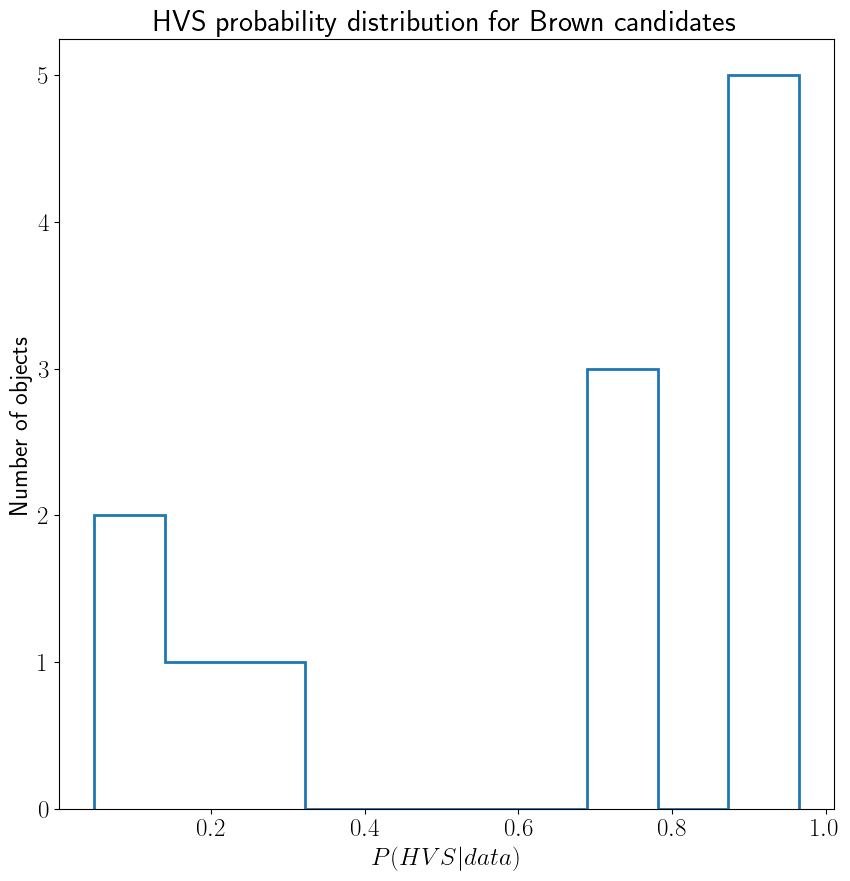

In [15]:
plt.figure(figsize=(10, 10))
plt.hist(brown_stars['prob_hvs'], bins=10, histtype='step', lw=2, label='HVS')
plt.xlabel('$P(HVS|data)$')
plt.ylabel('Number of objects')
plt.title('HVS probability distribution for Brown candidates')
plt.show()


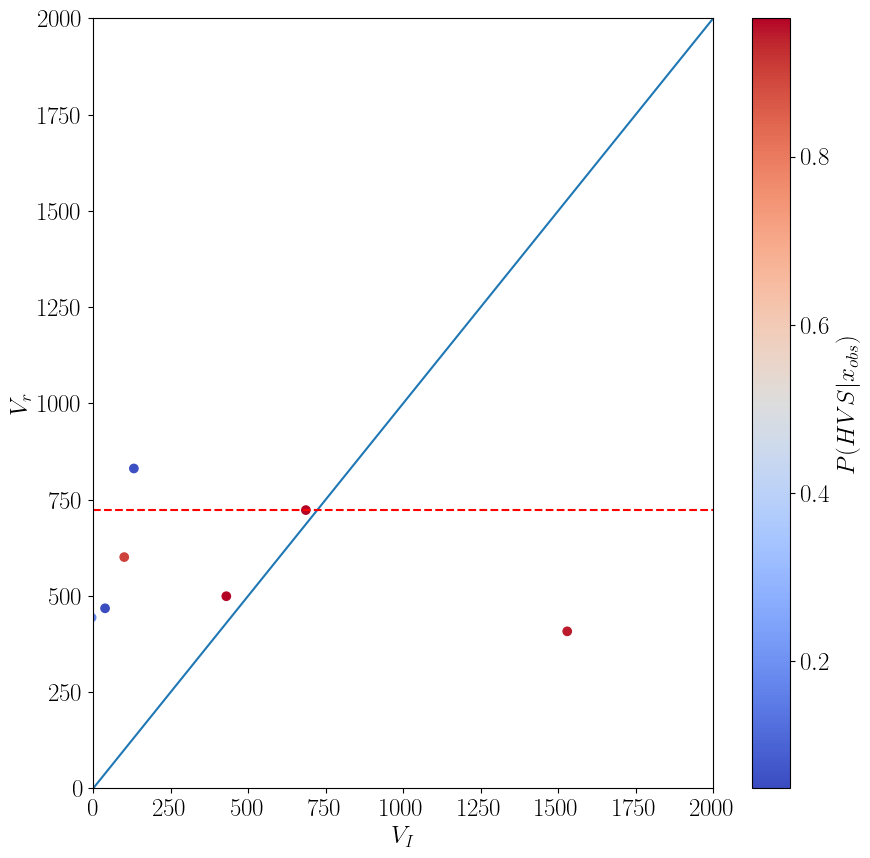

In [16]:
plt.figure(figsize=(10, 10))
cbar = plt.scatter(brown_stars['VR']/1e1, brown_stars['v_helio'], c = brown_stars['prob_hvs'], cmap='coolwarm')
#plt.errorbar(brown_stars['VR']/1e1, brown_stars['v_helio'], xerr=0, yerr=brown_stars['v_helio_error'], fmt='o')
x = np.linspace(0, 10000, 100)
plt.plot(x, x)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.colorbar(cbar, label='$P(HVS| x_{obs})$')
plt.hlines(723.000000, 0, 2000, colors='r', linestyles='dashed')
plt.xlabel('$V_I$')
plt.ylabel('$V_r$')
plt.show()

In [17]:
brown_stars

ID           R.A., Decl.(J2000)     v_helio  v_helio_error  \
0    b'HVS 1'   b'9:07:44.99, +02:45:06.9'  831.099976            5.7   
1    b'HVS 2'   b'9:33:20.87, +44:17:05.5'  708.000000           15.0   
2    b'HVS 3'    b'4:38:12.77, 54:33:11.9'  723.000000            3.0   
3    b'HVS 4'   b'9:13:01.00, +30:51:19.9'  600.900024            6.2   
4    b'HVS 5'   b'9:17:59.47, +67:22:38.3'  545.500000            4.3   
5    b'HVS 7'  b'11:33:12.13, +01:08:24.8'  526.900024            3.0   
6    b'HVS 8'   b'9:42:14.03, +20:03:22.0'  499.299988            2.9   
7    b'HVS 9'   b'10:21:37.08, 00:52:34.7'  616.799988            5.1   
8   b'HVS 10'  b'12:03:37.85, +18:02:50.3'  467.899994            5.6   
9   b'HVS 12'  b'10:50:09.60, +03:15:50.6'  552.200012            6.6   
10  b'HVS 13'   b'10:52:48.31, 00:01:33.9'  569.299988            6.1   
11    b'B434'  b'11:02:24.37, +02:50:02.8'  443.899994            2.9   
12    b'B485'  b'10:10:18.82, +30:20:28.1'  408.100006            4.8   
13    b'B711'  b'14:20:01.94, +12:44:04.7'  273.700012            5.4   
14    b'B733'  b'14:49:55.58, +31:03:51.3'  348.799988            2.3   

       Teff  Teff_error  log_g  log_g_error  v_sin_i  v_sin_i_error  ...  \
0   11192.0       450.0   3.91         0.20    158.0           36.0  ...   
1   44561.0       675.0   5.23         0.12      NaN            NaN  ...   
2   23000.0      1000.0   3.95         0.10     55.0            2.0  ...   
3   14547.0       598.0   4.15         0.21     77.0           40.0  ...   
4   12000.0       350.0   3.89         0.13    133.0            7.0  ...   
5   12000.0       500.0   3.80         0.10     55.0            2.0  ...   
6   11000.0      1000.0   3.75         0.25    320.0           60.0  ...   
7   11637.0       520.0   3.84         0.21    306.0           72.0  ...   
8   11278.0       524.0   4.38         0.23     37.0           60.0  ...   
9   12098.0       622.0   4.62         0.28     78.0           88.0  ...   
10  11054.0       775.0   4.00         0.35    238.0           43.0  ...   
11  10232.0       382.0   3.93         0.20    117.0           42.0  ...   
12  16167.0       542.0   4.02         0.12     88.0           69.0  ...   
13  11004.0       298.0   4.27         0.15     60.0           76.0  ...   
14  10522.0       301.0   4.25         0.14    240.0           28.0  ...   

    implied_parallax_error           VGCR             VR  bp_rp_corr_error  \
0                -0.013527    1166.792948    1314.968426          2.296204   
1                -0.003179   -3577.770073    3473.100767          1.999268   
2                 0.001519    6706.322155    6862.940909          2.476301   
3                -0.003895     956.025202    1003.893243          2.293671   
4                -0.002451    -172.383767    -274.215842          2.348811   
5                -0.003198  156765.298237  156887.334684          2.377694   
6                -0.003116    4217.788693    4296.462436          2.044880   
7                -0.015255   -1675.074463   -1508.619783          2.795405   
8                -0.005582     342.905265     385.453550          2.103155   
9                -0.015301   13090.665927  -12938.313386          2.476939   
10               -0.016023   -7308.897816   -7161.815653          2.386690   
11               -0.003667    -188.226311     -47.911087          2.992767   
12               -0.001071   15262.837777   15293.931574          3.165644   
13               -0.001645   -1253.472543   -1230.290385          3.050316   
14               -0.000643    -242.124421    -284.114610          2.400953   

    implied_M_g_corr  implied_M_g_corr_error is_hvs  prob_hvs  prob_non_hvs  \
0           1.489482               -0.698618  False  0.056859      0.943141   
1                NaN                     NaN  False       NaN           NaN   
2          -3.165326               -2.918159   True  0.964420      0.035580   
3          -0.998615               -1.809697   True  0.89704

In [18]:
brown_stars.ID

0      b'HVS 1'
1      b'HVS 2'
2      b'HVS 3'
3      b'HVS 4'
4      b'HVS 5'
5      b'HVS 7'
6      b'HVS 8'
7      b'HVS 9'
8     b'HVS 10'
9     b'HVS 12'
10    b'HVS 13'
11      b'B434'
12      b'B485'
13      b'B711'
14      b'B733'
Name: ID, dtype: object

In [19]:
mu_ra = [0.08, -7.33, 0.52, -0.23, 0.55, 0.05, 1, -0.82, -1.26, -1.07, -0.40, -0.9, -1.61, -1.66, -0.96, -1.77]
mu_ra_error = [0.26, 0.58, 0.58, 0.36, 0.61, 0.57, 0.82, 1.16, 0.74, 0.36, 0.36, 0.38, 0.28, 0.52, 0.80, 0.79]

mu_dec = [-0.12, 2.28, 1.65, -0.42, -0.44, 0.31, -0.55, -0.04, -0.25, -0.58, 0.31, 0.46, -0.26, -1.15, 1.55, -3.71 ]
mu_dec_error = [0.22, 0.55, 0.57, 0.36, 0.59, 0.97, 1.04, 0.49, 0.7, 0.42, 0.34, 0.44, 0.42,  0.38, 0.86, 0.89]


# for the ones in gaia drop the 6th one
mu_ra = np.delete(mu_ra, 5)
mu_ra_error = np.delete(mu_ra_error, 5)
mu_dec = np.delete(mu_dec, 5)
mu_dec_error = np.delete(mu_dec_error, 5)


In [20]:
brown_stars['mu_ra'] = mu_ra
brown_stars['mu_ra_error'] = mu_ra_error
brown_stars['mu_dec'] = mu_dec
brown_stars['mu_dec_error'] = mu_dec_error


# How much better is Gaia DR3 than Hubble

In [21]:
print('Brown et al. 2015 Hubble astrometry uncertainty in pmra:', np.average(brown_stars['mu_ra_error']/brown_stars['pmra_error']), 'times larger than Gaia')
print('Brown et al. 2015 Hubble astrometry uncertainty in pmdec:', np.average(brown_stars['mu_dec_error']/brown_stars['pmdec_error']), 'times larger than Gaia')

Brown et al. 2015 Hubble astrometry uncertainty in pmra: 5.928909561125393 times larger than Gaia
Brown et al. 2015 Hubble astrometry uncertainty in pmdec: 5.410031645651344 times larger than Gaia


# Orbit integration

In [22]:
good_star = brown_stars.loc[brown_stars['ID'] == b'HVS 3']

In [23]:
# Extract data and errors
ra = good_star['RAx'].iloc[0]
dec = good_star['DECx'].iloc[0]
pmra = good_star['pmra'].iloc[0]
pmdec = good_star['pmdec'].iloc[0]
d_helio = good_star['d_helio'].iloc[0]
v_helio = good_star['v_helio'].iloc[0]
pmra_err = good_star['pmra_error'].iloc[0]
pmdec_err = good_star['pmdec_error'].iloc[0]
d_helio_err = good_star['d_helio_error'].iloc[0]
v_helio_err = good_star['v_helio_error'].iloc[0]

print('HVS 3')
print('RA:', ra)
print('DEC:', dec)
print('pmra:', pmra)
print('pmdec:', pmdec)
print('d_helio:', d_helio)
print('v_helio:', v_helio)
print('pmra_err:', pmra_err)
print('pmdec_err:', pmdec_err)
print('d_helio_err:', d_helio_err)
print('v_helio_err:', v_helio_err)

HVS 3
RA: 69.55320833333333
DEC: -54.553305555555546
pmra: 0.853
pmdec: 1.614
d_helio: 61.0
v_helio: 723.0
pmra_err: 0.049
pmdec_err: 0.061
d_helio_err: 10.0
v_helio_err: 3.0


# Lifetime

In [24]:
import numpy as np

def get_expected_lifetime(feh, teff, logg):
    """
    Estimate the expected lifetime of a main-sequence star given its metallicity (feh),
    effective temperature (teff), and surface gravity (logg).

    Parameters:
    feh : float
        Metallicity [Fe/H] of the star (not directly used in this approximation).
    teff : float
        Effective temperature of the star in Kelvin.
    logg : float
        Surface gravity of the star in cgs units (log g).

    Returns:
    total_lifetime : float
        Expected total lifetime of the star in years.
    """
    # Constants
    G = 6.67430e-8       # Gravitational constant in cm^3 g^-1 s^-2
    Msun = 1.98847e33    # Solar mass in grams
    Rsun = 6.957e10      # Solar radius in cm
    Lsun = 3.828e33      # Solar luminosity in erg/s
    sigma = 5.670374419e-5  # Stefan-Boltzmann constant in erg cm^-2 s^-1 K^-4

    # Convert logg from log10 to linear units (cm/s^2)
    g_star = 10 ** logg

    # Estimate stellar radius using the surface gravity equation: g = G * M / R^2
    # We need an estimate of the mass to proceed, but since we have two equations,
    # we can solve for mass and radius simultaneously.

    # Assume mass-luminosity relation for main-sequence stars: L / Lsun = (M / Msun) ^ 3.5
    # Assume mass-radius relation: R / Rsun = (M / Msun) ^ 0.8

    # Using the mass-radius relation to express R in terms of M
    def radius_from_mass(mass):
        return Rsun * (mass / Msun) ** 0.8

    # Using the surface gravity equation to express g in terms of M and R
    def gravity(mass, radius):
        return G * mass / radius ** 2

    # Define a function to find the mass that satisfies the given surface gravity
    def mass_function(mass_guess):
        radius = radius_from_mass(mass_guess)
        g_calculated = gravity(mass_guess, radius)
        return np.log10(g_calculated) - logg

    # Use numerical methods to solve for the mass
    from scipy.optimize import fsolve

    # Initial guess for mass (in grams)
    mass_guess = Msun

    # Solve for mass
    mass_solution, info, ier, mesg = fsolve(mass_function, mass_guess, full_output=True)

    if ier != 1:
        raise RuntimeError("Could not solve for mass: " + mesg)

    mass = mass_solution[0]  # Mass in grams

    # Convert mass to solar masses
    mass_Msun = mass / Msun

    # Estimate the stellar lifetime using the mass-lifetime relation
    # For main-sequence stars, lifetime scales as (M / Msun) ^ (-2.5)
    total_lifetime = 1e10 * mass_Msun ** -2.5  # in years

    return total_lifetime


In [25]:
# Given parameters
feh = 0.3      # Solar metallicity (not directly used in this approximation)
teff = good_star['Teff']    # Effective temperature of the Sun in Kelvin
logg = good_star['log_g']    # Surface gravity of the Sun in cgs units (log g)

# Estimate the expected lifetime
lifetime = get_expected_lifetime(feh, teff, logg)
print(f"Expected lifetime of the star: {lifetime:.2e} years")


Expected lifetime of the star: 9.25e+07 years


I only want to integrate during the lifetime of the star, as it is not interesting if the star is dead

# General orbit integration posterior

In [26]:
from galpy.potential import MWPotential2014

def integrate_orbits(star, output_path=None, n_samples=1000, integration_time=-92*u.Myr, n_steps=10000):
    """
    Integrate orbits of a star back in time and estimate posterior distribution
    for its origin position.
    """
    # Use MWPotential2014
    pot = MWPotential2014

    # Define physical scales
    ro = 8.0  # Distance scale in kpc (e.g., Sun-Galactic Center distance)
    vo = 220.0  # Velocity scale in km/s

    # Create time grid
    time_grid = np.linspace(0, integration_time.value, n_steps) * integration_time.unit
    
    # Extract data and errors
    ra = star['RAx'].iloc[0]
    dec = star['DECx'].iloc[0]
    pmra = star['pmra'].iloc[0]
    pmdec = star['pmdec'].iloc[0]
    d_helio = star['d_helio'].iloc[0]
    v_helio = star['v_helio'].iloc[0]
    pmra_err = star['pmra_error'].iloc[0]
    pmdec_err = star['pmdec_error'].iloc[0]
    d_helio_err = star['d_helio_error'].iloc[0]
    v_helio_err = star['v_helio_error'].iloc[0]
    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    star_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbits for each sample
    for i in range(n_samples):
        # Transform to Galactocentric frame
        c = SkyCoord(ra=ra_samples[i]*u.deg, dec=dec_samples[i]*u.deg, 
                      distance=d_samples[i]*u.kpc, pm_ra_cosdec=pmra_samples[i]*u.mas/u.yr, 
                      pm_dec=pmdec_samples[i]*u.mas/u.yr, radial_velocity=v_samples[i]*u.km/u.s)
        galactic = c.transform_to(Galactocentric())

        # Initialize orbit
        vx = galactic.v_x.to_value(u.km/u.s)
        vy = galactic.v_y.to_value(u.km/u.s)
        vz = galactic.v_z.to_value(u.km/u.s)
        o = Orbit(vxvv=[galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc), 
                        vx, vy, vz], ro=ro, vo=vo, solarmotion='schoenrich')
        
        # Integrate orbit
        o.integrate(time_grid, pot)
        
        # Record origin position
        star_origins.append([o.x(time_grid[-1]), o.y(time_grid[-1]), o.z(time_grid[-1])])
        
        # # Save orbit data to file
        # if output_path:
        #     orbit_data = np.array([o.x(time_grid), o.y(time_grid), o.z(time_grid),
        #                            o.vx(time_grid), o.vy(time_grid), o.vz(time_grid)]).T
        #     filename = os.path.join(output_path, f"star_sample_{i}.txt")
        #     np.savetxt(filename, orbit_data, 
        #                header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return star_origins


In [27]:
def integrate_orbits_to_closest_point(star, output_path=None, n_samples=100, integration_time=-10*u.Gyr, n_steps=3000, pot= MWPotential2014):
    """
    Integrate orbits of a star back in time and find the closest approach to X, Y, Z = 0.
    
    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio', 
                                         'pmra_error', 'pmdec_error', 'd_helio_error', 'v_helio_error'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: Quantity
      Integration time into the past (negative for backward integration).
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """

    # Define physical scales
    ro = 8.0  # Distance scale in kpc (e.g., Sun-Galactic Center distance)
    vo = 220.0  # Velocity scale in km/s

    # Create time grid
    time_grid = np.linspace(0, integration_time.value, n_steps) * integration_time.unit
    
    # Extract data and errors
    ra = star['RAx'].iloc[0]
    dec = star['DECx'].iloc[0]
    pmra = star['pmra'].iloc[0]
    pmdec = star['pmdec'].iloc[0]
    d_helio = star['d_helio'].iloc[0]
    v_helio = star['v_helio'].iloc[0]
    pmra_err = star['pmra_error'].iloc[0]
    pmdec_err = star['pmdec_error'].iloc[0]
    d_helio_err = star['d_helio_error'].iloc[0]
    v_helio_err = star['v_helio_error'].iloc[0]
    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    closest_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbits for each sample
    for i in range(n_samples):
        # Transform to Galactocentric frame
        c = SkyCoord(ra=ra_samples[i]*u.deg, dec=dec_samples[i]*u.deg, 
                      distance=d_samples[i]*u.kpc, pm_ra_cosdec=pmra_samples[i]*u.mas/u.yr, 
                      pm_dec=pmdec_samples[i]*u.mas/u.yr, radial_velocity=v_samples[i]*u.km/u.s)
        galactic = c.transform_to(Galactocentric())
        
        # Initialize orbit
        vx = galactic.v_x.to_value(u.km/u.s)
        vy = galactic.v_y.to_value(u.km/u.s)
        vz = galactic.v_z.to_value(u.km/u.s)
        o = Orbit(vxvv=[galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc), 
                        vx, vy, vz], ro=ro, vo=vo, solarmotion='schoenrich')
        
        # Integrate orbit
        o.integrate(time_grid, pot)
        
        # Find the periapse to the Galactic Center
        x, y, z = o.x(time_grid), o.y(time_grid), o.z(time_grid)
        distances = np.sqrt(x**2 + y**2 + z**2)
        min_idx = np.argmin(distances)
        periapse = (x[min_idx], y[min_idx], z[min_idx])
        closest_origins.append(periapse)
        
        # Save orbit data to file (optional)
        if output_path:
            orbit_data = np.array([x, y, z, o.vx(time_grid), o.vy(time_grid), o.vz(time_grid)]).T
            filename = os.path.join(output_path, f"star_sample_{i}.txt")
            np.savetxt(filename, orbit_data, 
                       header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return closest_origins


In [28]:
origins_brown = integrate_orbits(good_star, n_samples=100, integration_time=-10*u.Myr, n_steps=1000)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_origins(origins):
    """
    Plot posterior distributions of star origins with contours in the X-Y plane.
    
    Parameters:
    - origins: list of lists
      List containing origin positions as astropy.Quantity objects.
    """
    # Extract X, Y positions
    x = np.array([origin[0].value for origin in origins])
    y = np.array([origin[1].value for origin in origins])
    
    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Plot the KDE as a contour plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=30, cmap="Blues")
    plt.colorbar(label="Density")
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark the Galactic Center
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.title('Posterior Distribution of Star Origins (X-Y Plane)')
    plt.legend()
    plt.grid(True)
    plt.show()


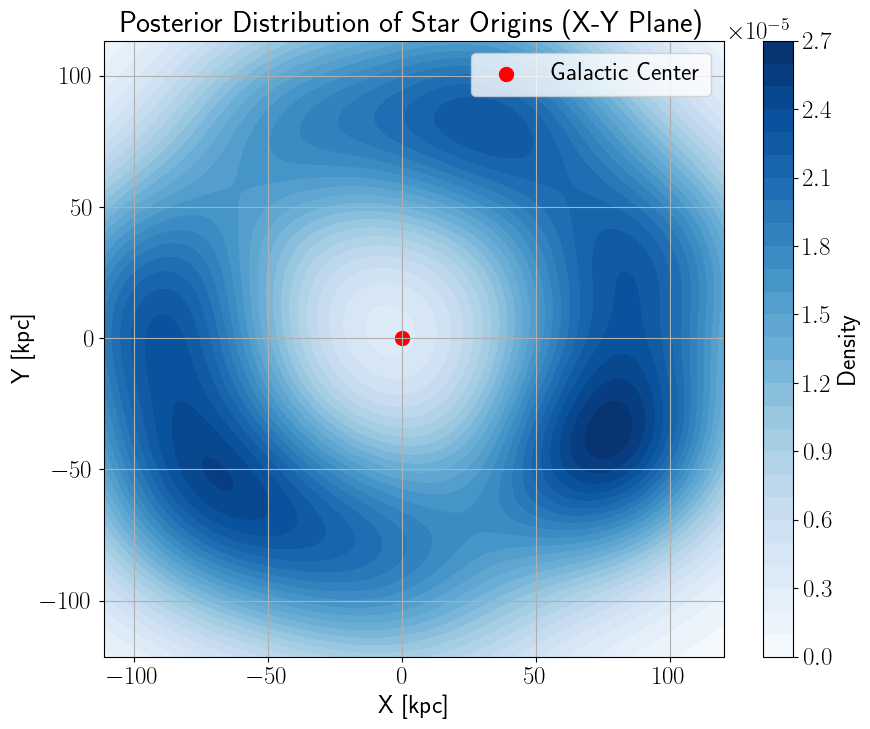

In [30]:
plot_origins(origins_brown)


# Plot to closest point

Integrate within a given time, set by the main sequence lifetime of the star. Then plot the distribution of the periapse distance to the GC.

In [35]:
origins_brown_closest = integrate_orbits_to_closest_point(good_star, n_samples=100, integration_time=-92*u.Myr, n_steps=10000)

In [36]:
def plot_closest_origins(origins):
    """
    Plot the closest approach points in the X-Y plane.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    """
    # Extract X, Y positions
    x = np.array([origin[0].value for origin in origins])
    y = np.array([origin[1].value for origin in origins])
    
    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Plot the KDE as a contour plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=30, cmap="Blues")
    plt.colorbar(label="Density")
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark the Galactic Center
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.title('Closest Approach Points in X-Y Plane')
    plt.legend()
    plt.grid(True)
    plt.show()


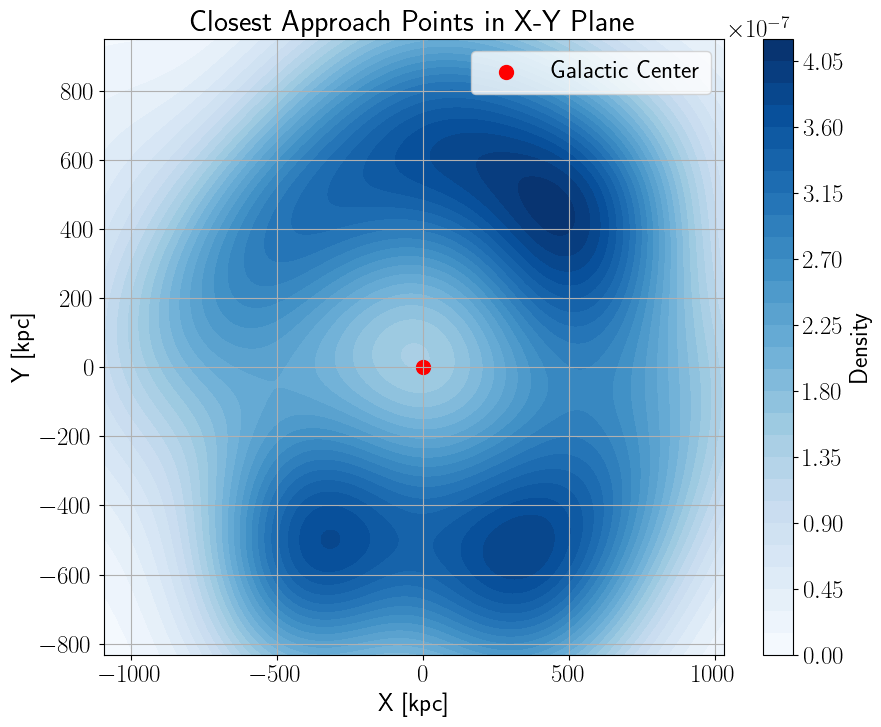

In [37]:
plot_closest_origins(origins_brown_closest)

In [38]:
# now for all stars
path_to_save = '/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/orbits'
origin_all = []
for i in tqdm(range(len(brown_stars))):
    origins = integrate_orbits_to_closest_point(brown_stars.iloc[[i]], n_samples=100, integration_time=-92*u.Myr, n_steps=1000)
    origin_all.append(origins)


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


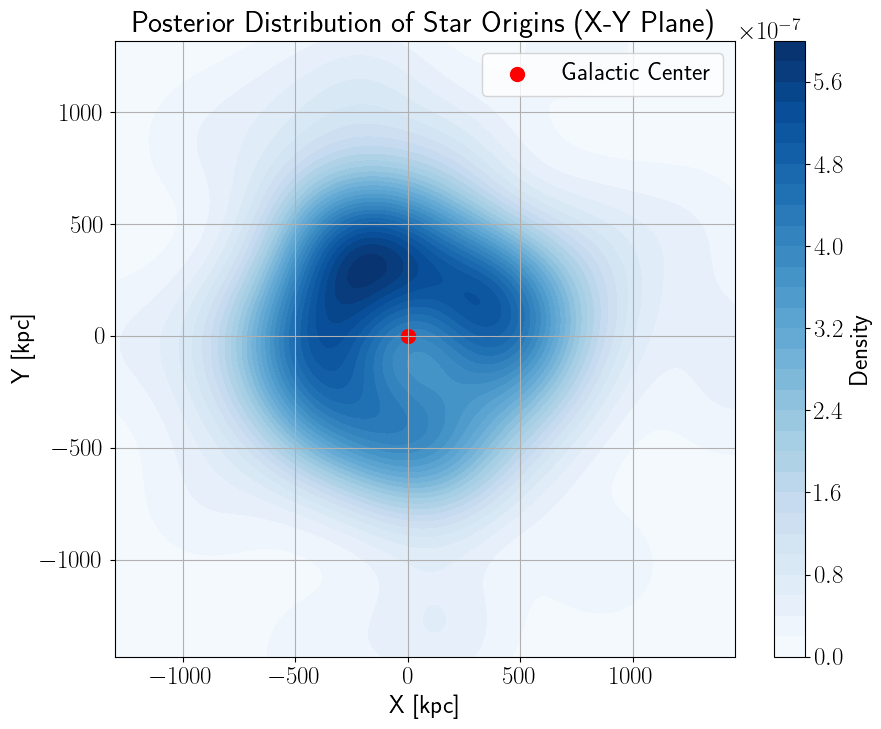

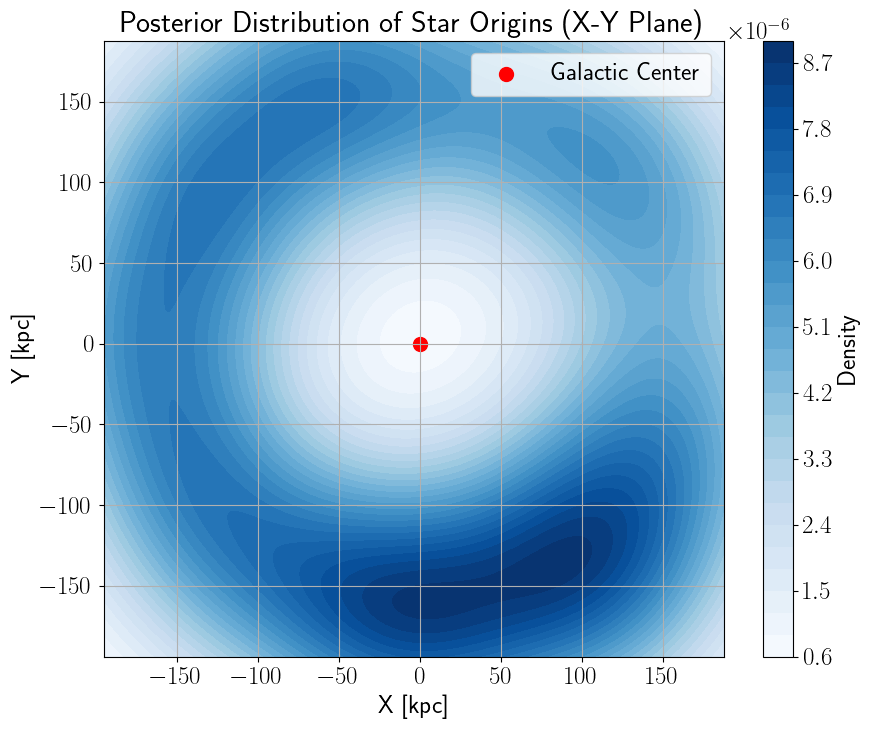

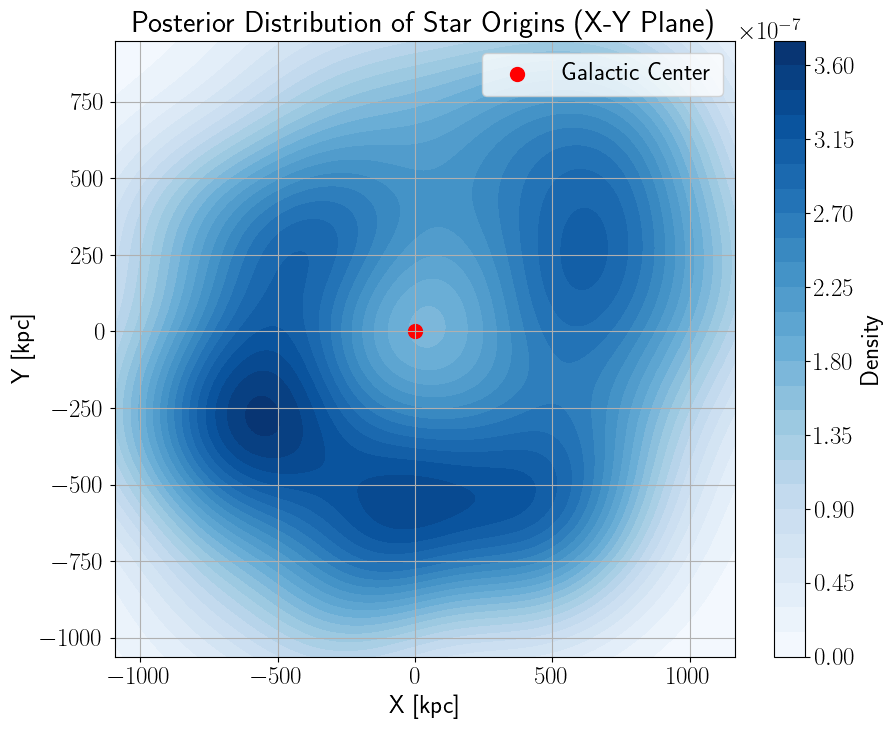

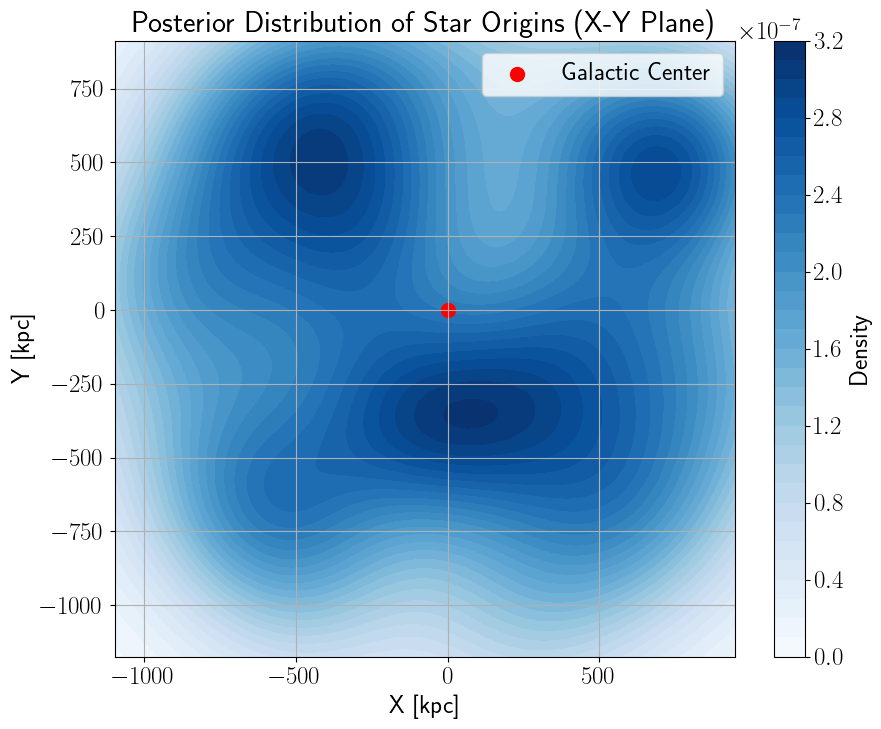

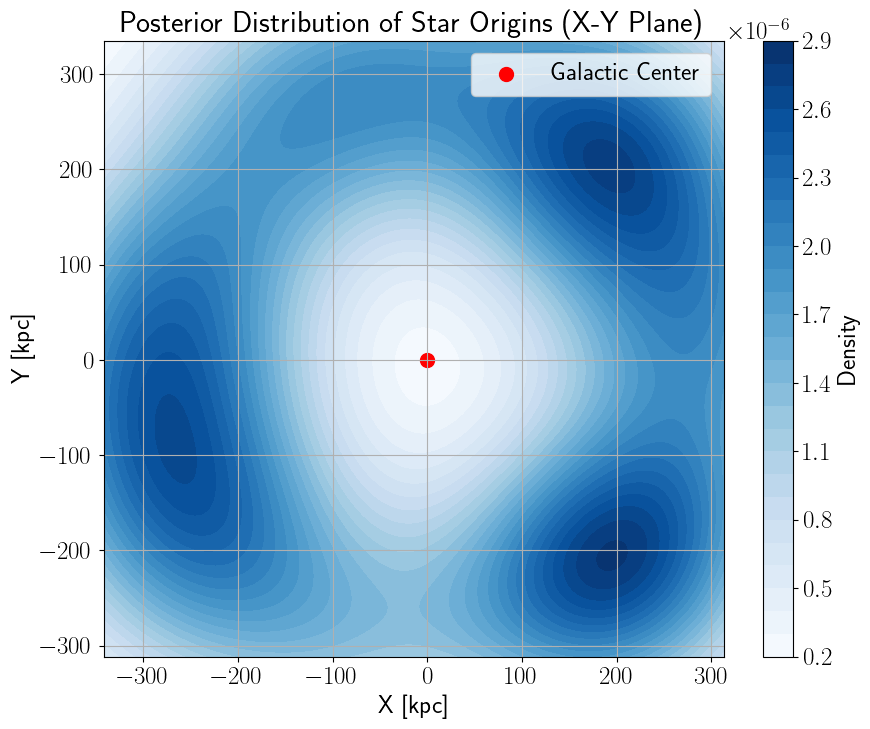

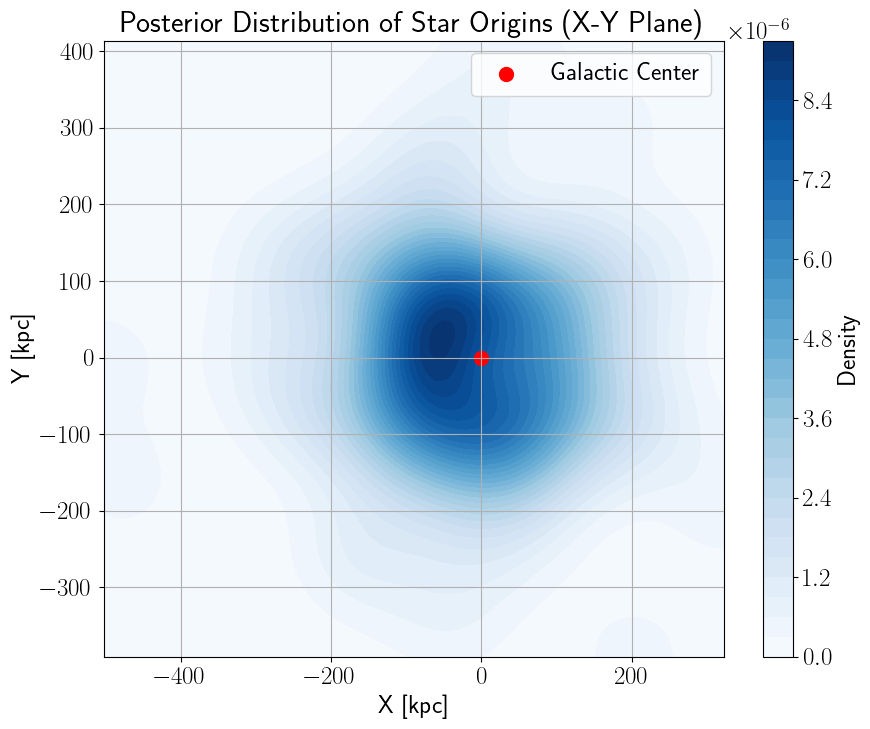

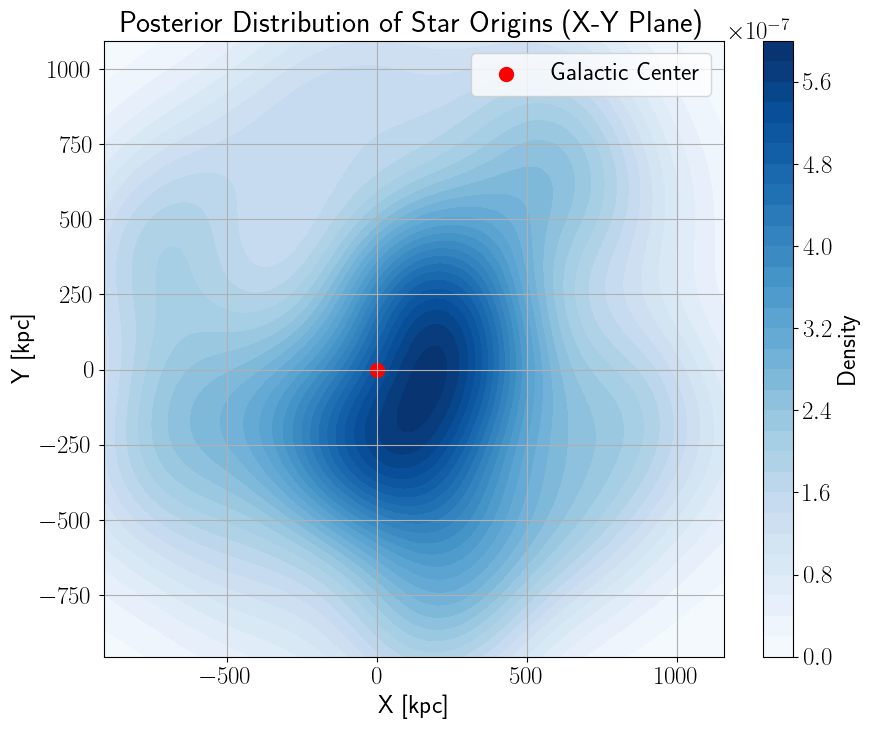

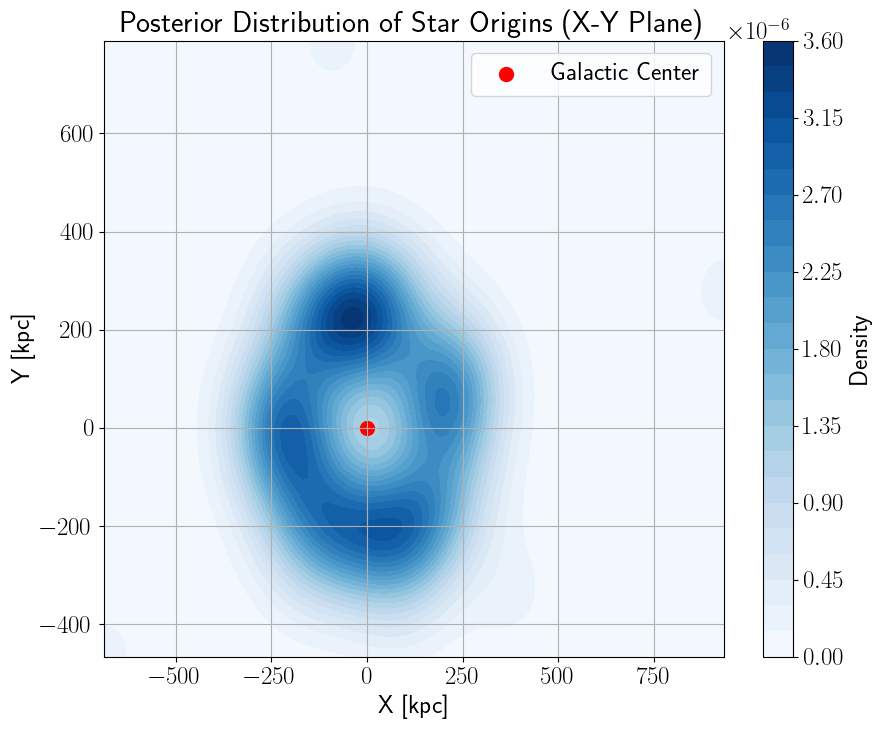

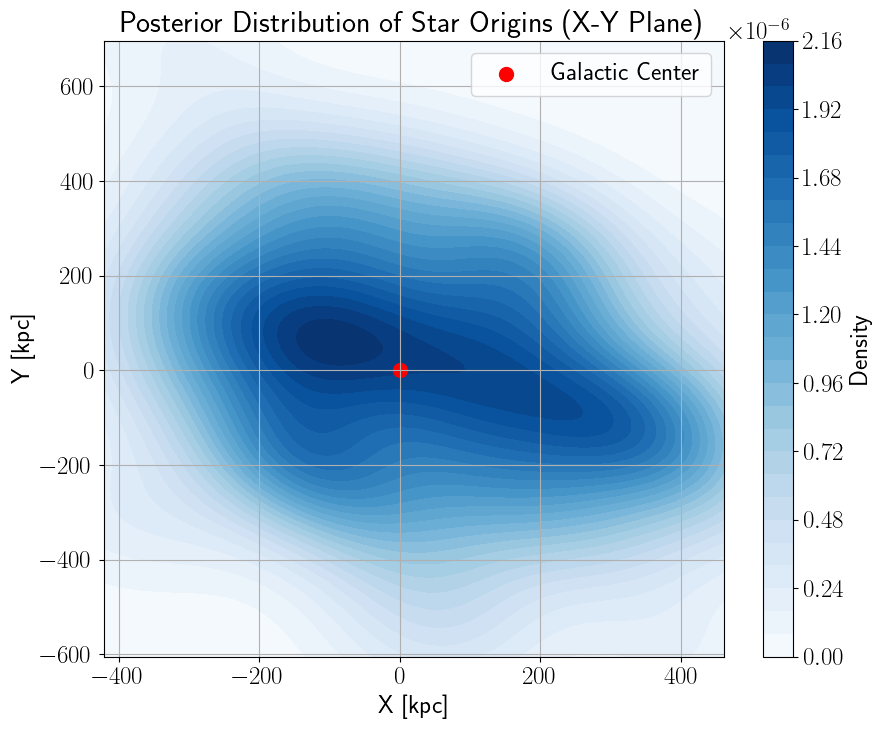

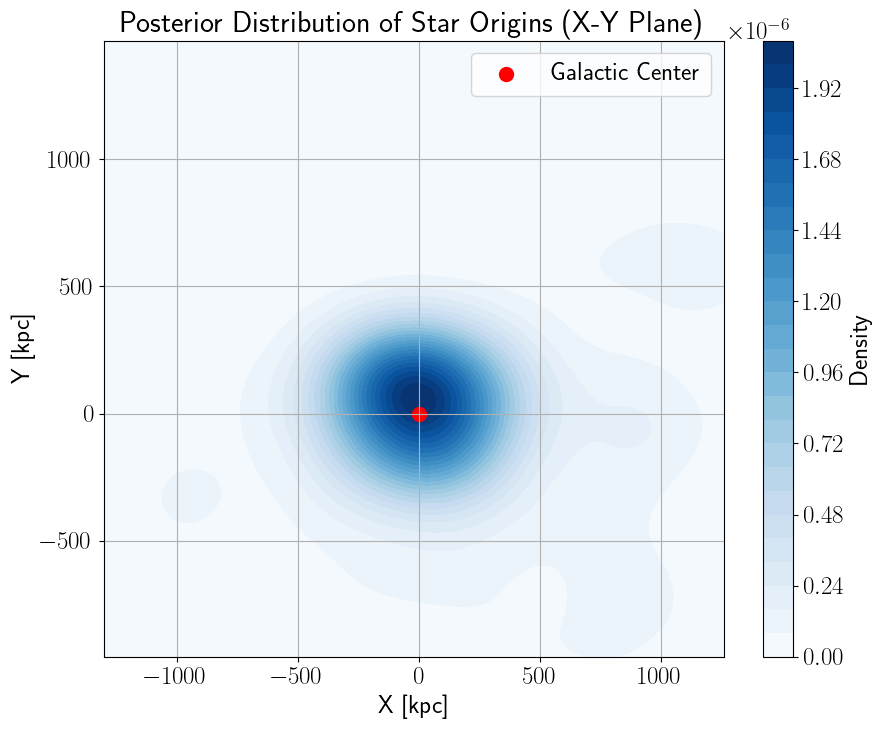

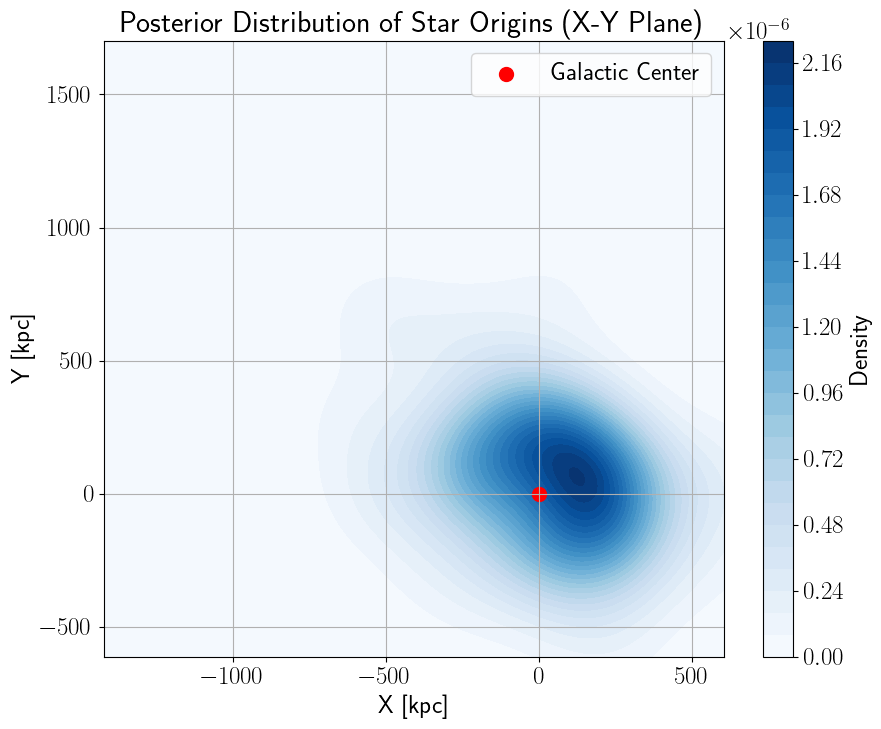

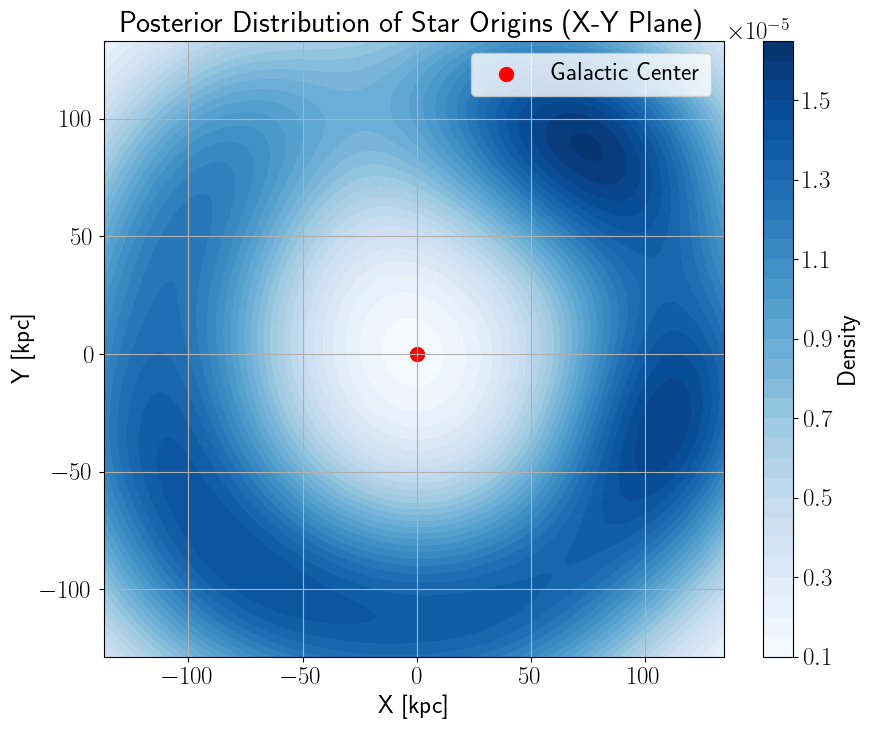

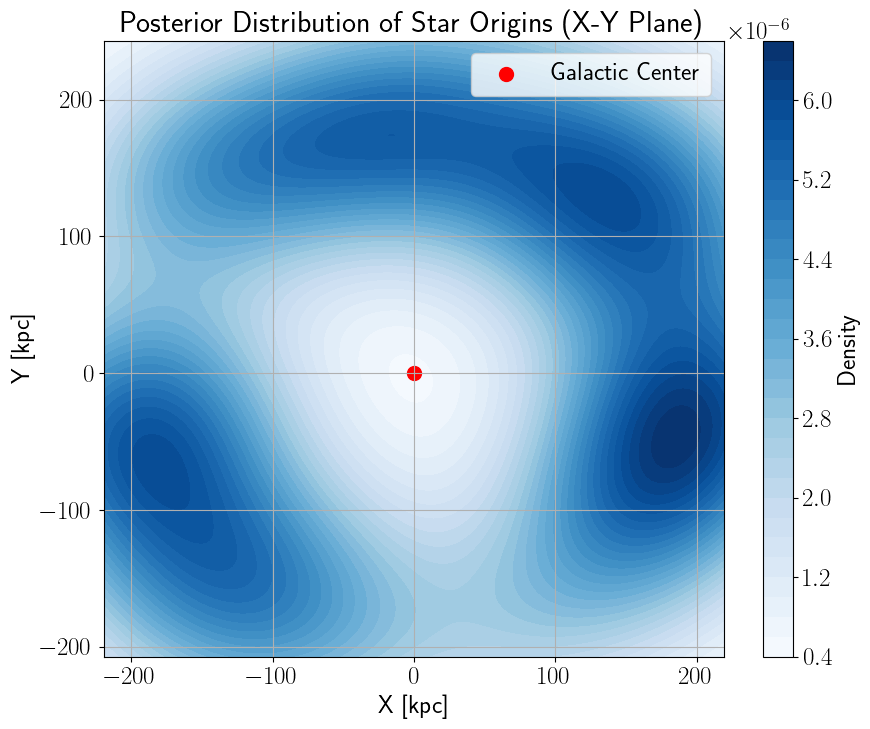

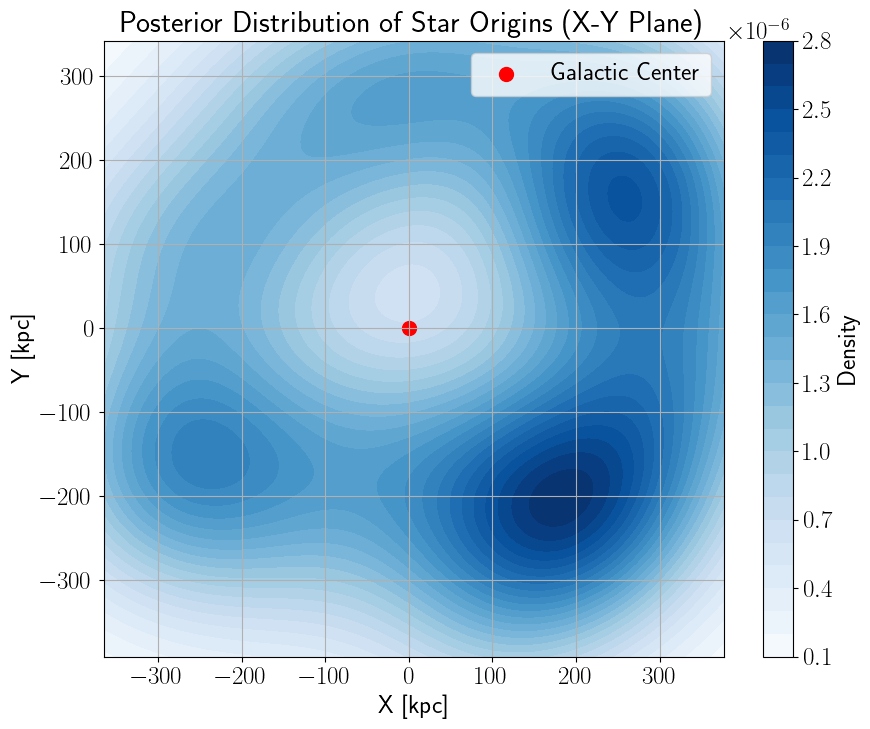

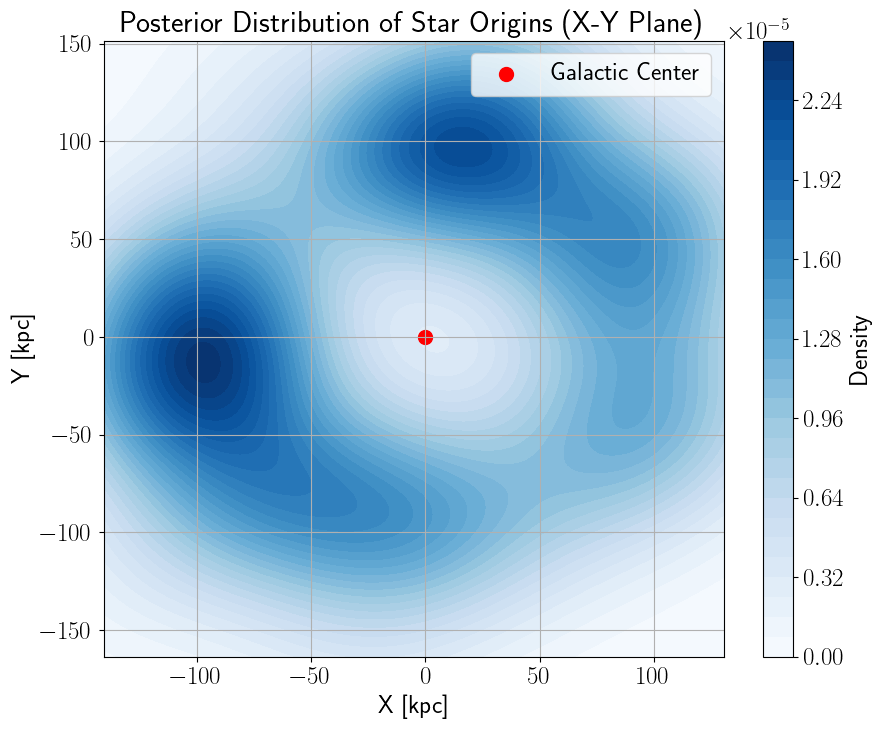

In [57]:
for i in range(len(brown_stars)):
    plot_origins(origin_all[i])

# Galactic plane crossing location

In [39]:
def integrate_orbits_to_plane_crossing(star, ra_col = 'RAx', dec_col = 'DECx', pmra_col = 'pmra',
                                        pmdec_col = 'pmdec', d_col = 'd_helio', v_col = 'v_helio',
                                        pmra_error_col = 'pmra_error', pmdec_error_col = 'pmdec_error',
                                        d_col_error = 'd_helio_error', v_col_error = 'v_helio_error',
                                       output_path=None, n_samples=100, integration_time=-10*u.Gyr, 
                                       n_steps=1000, pot= MWPotential2014):
    """
    Integrate orbits of a star back in time and find the closest approach to X, Y, Z = 0.
    
    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio', 
                                         'pmra_error', 'pmdec_error', 'd_helio_error', 'v_helio_error'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: Quantity
      Integration time into the past (negative for backward integration).
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """

    # Define physical scales
    ro = 8.21  # Distance scale in kpc (e.g., Sun-Galactic Center distance)
    vo = 233.1  # Velocity scale in km/s

    # Create time grid
    time_grid = np.linspace(0, integration_time.value, n_steps) * integration_time.unit
    
    # Extract data and errors
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]
    pmra_err = star[pmra_error_col].iloc[0]
    pmdec_err = star[pmdec_error_col].iloc[0]
    d_helio_err = star[d_col_error].iloc[0]
    v_helio_err = star[v_col_error].iloc[0]
    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    closest_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbits for each sample
    for i in range(n_samples):
        # Transform to Galactocentric frame
        c = SkyCoord(ra=ra_samples[i]*u.deg, dec=dec_samples[i]*u.deg, 
                      distance=d_samples[i]*u.kpc, pm_ra_cosdec=pmra_samples[i]*u.mas/u.yr, 
                      pm_dec=pmdec_samples[i]*u.mas/u.yr, radial_velocity=v_samples[i]*u.km/u.s)
        galactic = c.transform_to(Galactocentric())
        
        # Initialize orbit
        vx = galactic.v_x.to_value(u.km/u.s)
        vy = galactic.v_y.to_value(u.km/u.s)
        vz = galactic.v_z.to_value(u.km/u.s)
        o = Orbit(vxvv=[galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc), 
                        vx, vy, vz], ro=ro, vo=vo, solarmotion='schoenrich')
        
        # Integrate orbit
        o.integrate(time_grid, pot)
        
        # Find the x, y position at the plane crossing
        x, y, z = o.x(time_grid), o.y(time_grid), o.z(time_grid)
        distances = np.sqrt(z**2)
        min_idx = np.argmin(distances)
        periapse = (x[min_idx], y[min_idx], z[min_idx])
        closest_origins.append(periapse)
        
        # Save orbit data to file (optional)
        if output_path:
            orbit_data = np.array([x, y, z, o.vx(time_grid), o.vy(time_grid), o.vz(time_grid)]).T
            filename = os.path.join(output_path, f"star_sample_{i}.txt")
            np.savetxt(filename, orbit_data, 
                       header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return closest_origins


In [101]:
from galpy.util.conversion import get_physical

def integrate_orbits_to_plane_crossing_mcmillan(star, ra_col = 'RAx', dec_col = 'DECx', pmra_col = 'pmra',
                                        pmdec_col = 'pmdec', d_col = 'd_helio', v_col = 'v_helio',
                                        pmra_error_col = 'pmra_error', pmdec_error_col = 'pmdec_error',
                                        d_col_error = 'd_helio_error', v_col_error = 'v_helio_error',
                                       output_path=None, n_samples=100, integration_time=-10*u.Gyr, 
                                       n_steps=3000):
    """
    Integrate orbits of a star back in time and find the closest approach to X, Y, Z = 0.
    
    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio', 
                                         'pmra_error', 'pmdec_error', 'd_helio_error', 'v_helio_error'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: Quantity
      Integration time into the past (negative for backward integration).
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """

    # Define physical scales
    ro = 8.21  # Distance scale in kpc (e.g., Sun-Galactic Center distance)
    vo = 233.1  # Velocity scale in km/s

    # Create time grid
    time_grid = np.linspace(0, integration_time.value, n_steps) * integration_time.unit
    
    # Extract data and errors
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]
    pmra_err = star[pmra_error_col].iloc[0]
    pmdec_err = star[pmdec_error_col].iloc[0]
    d_helio_err = star[d_col_error].iloc[0]
    v_helio_err = star[v_col_error].iloc[0]
    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    closest_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbits for each sample
    for i in tqdm(range(n_samples)):
        # Transform to Galactocentric frame
        c = SkyCoord(ra=ra_samples[i]*u.deg, dec=dec_samples[i]*u.deg, 
                      distance=d_samples[i]*u.kpc, pm_ra_cosdec=pmra_samples[i]*u.mas/u.yr, 
                      pm_dec=pmdec_samples[i]*u.mas/u.yr, radial_velocity=v_samples[i]*u.km/u.s)
        galactic = c.transform_to(Galactocentric())
        
        # Initialize orbit
        vx = galactic.v_x.to_value(u.km/u.s)
        vy = galactic.v_y.to_value(u.km/u.s)
        vz = galactic.v_z.to_value(u.km/u.s)
        o = Orbit(vxvv=[galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc), 
                        vx, vy, vz], **get_physical(McMillan17))
        
        # Integrate orbit
        o.integrate(time_grid, McMillan17)
        
        # Find the x, y position at the plane crossing
        x, y, z = o.x(time_grid), o.y(time_grid), o.z(time_grid)
        distances = np.sqrt(z**2)
        min_idx = np.argmin(distances)
        periapse = (x[min_idx], y[min_idx], z[min_idx])
        closest_origins.append(periapse)
        
        # Save orbit data to file (optional)
        if output_path:
            orbit_data = np.array([x, y, z, o.vx(time_grid), o.vy(time_grid), o.vz(time_grid)]).T
            filename = os.path.join(output_path, f"star_sample_{i}.txt")
            np.savetxt(filename, orbit_data, 
                       header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return closest_origins

In [41]:
from galpy.potential.mwpotentials import McMillan17

In [43]:
# now for all stars
path_to_save = '/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/orbits'
plane_crossing = []
for i in tqdm(range(len(brown_stars))):
    origins = integrate_orbits_to_plane_crossing_mcmillan(brown_stars.iloc[[i]], n_samples=100, integration_time=-120*u.Myr, n_steps=1000)
    plane_crossing.append(origins)


100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


In [84]:
def plot_closest_origins(origins, xlim=(-30, 30), ylim=(-30, 30), circle = True):
    """
    Plot the closest approach points in the X-Y plane.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    """
    # Extract X, Y positions
    x = np.array([origin[0].value for origin in origins])
    y = np.array([origin[1].value for origin in origins])
    
    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Plot the KDE as a contour plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=30, cmap="Blues")
    plt.colorbar(label="Density")
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark the Galactic Center
    if circle:
        # solar circle
        circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
        # add circle with a 15 kpc radius
        circle2 = plt.Circle((0, 0), 15, color='g', fill=False, linestyle='--', label='15 kpc')
        plt.gca().add_artist(circle1)
        plt.gca().add_artist(circle2)

    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Plane crossing position')
    plt.legend(loc = 'upper right')
    plt.grid(True)
    plt.show()


Star: b'HVS 1'


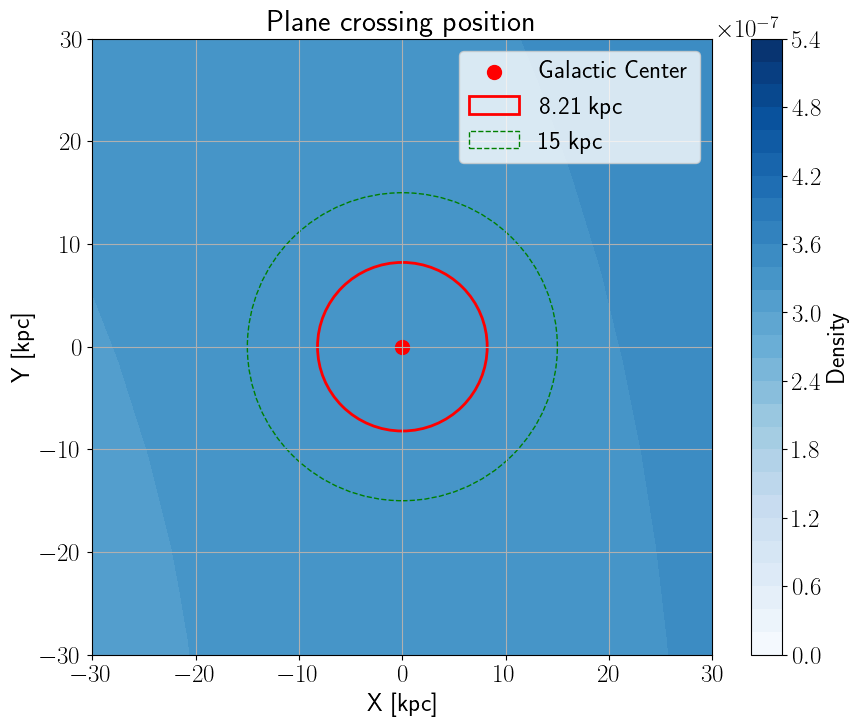

Star: b'HVS 2'


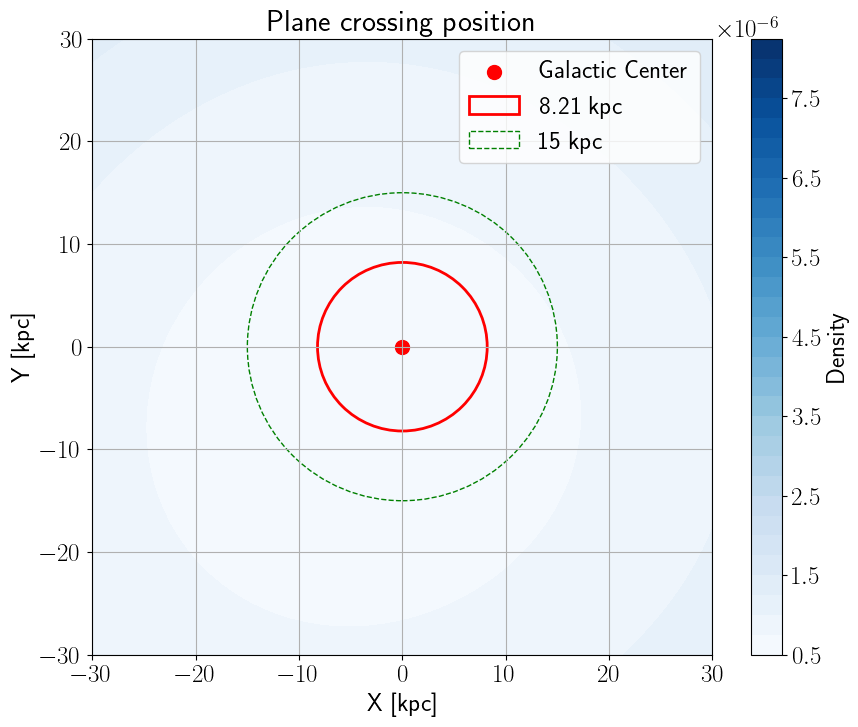

Star: b'HVS 3'


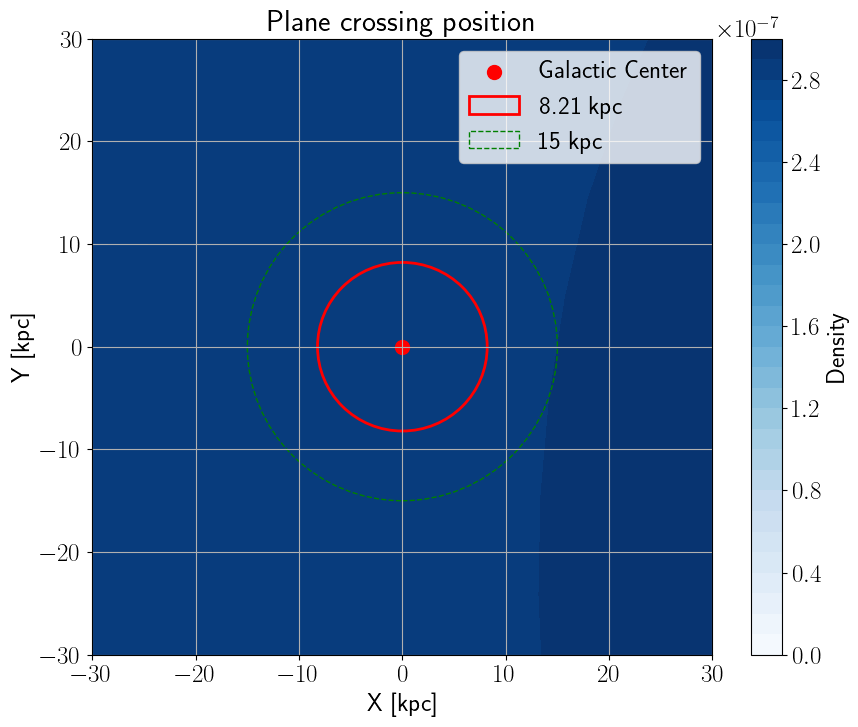

Star: b'HVS 4'


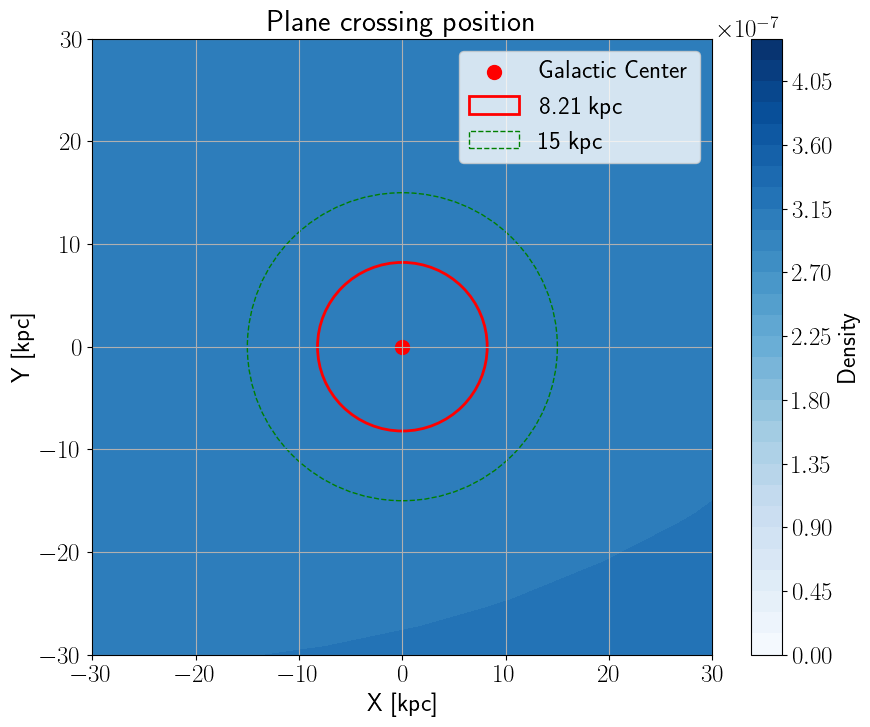

Star: b'HVS 5'


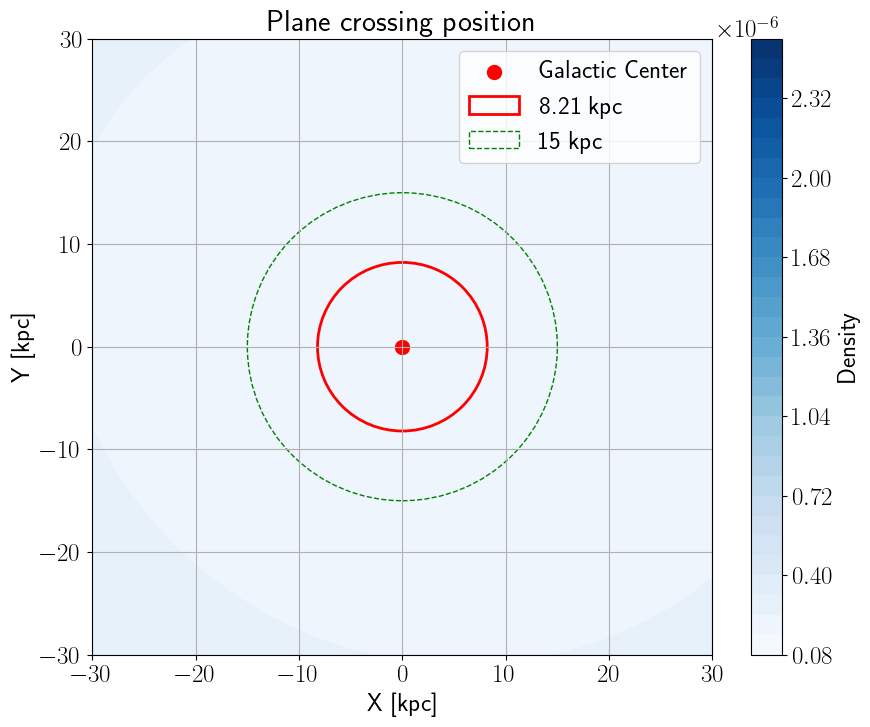

Star: b'HVS 7'


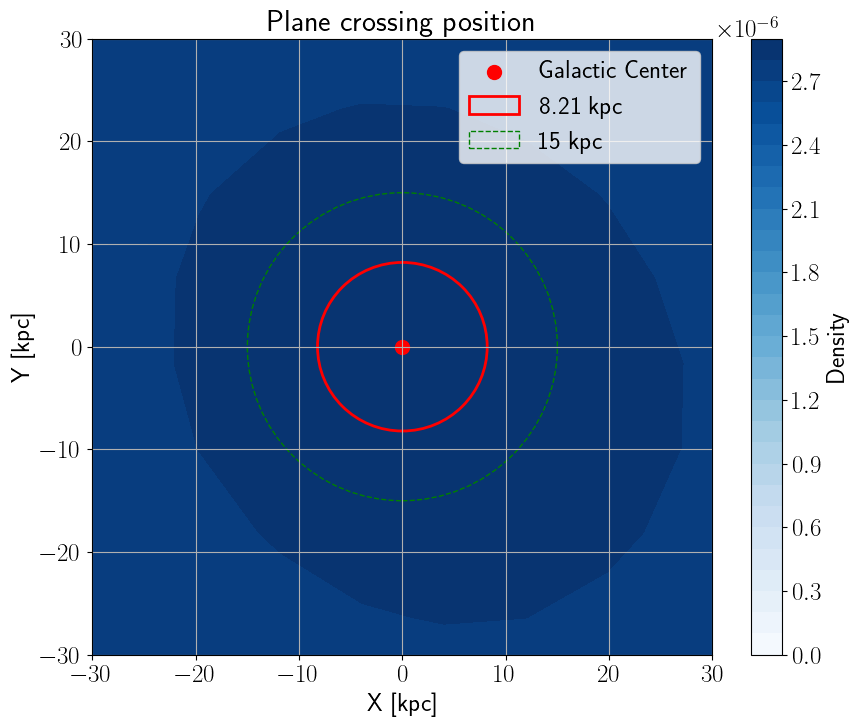

Star: b'HVS 8'


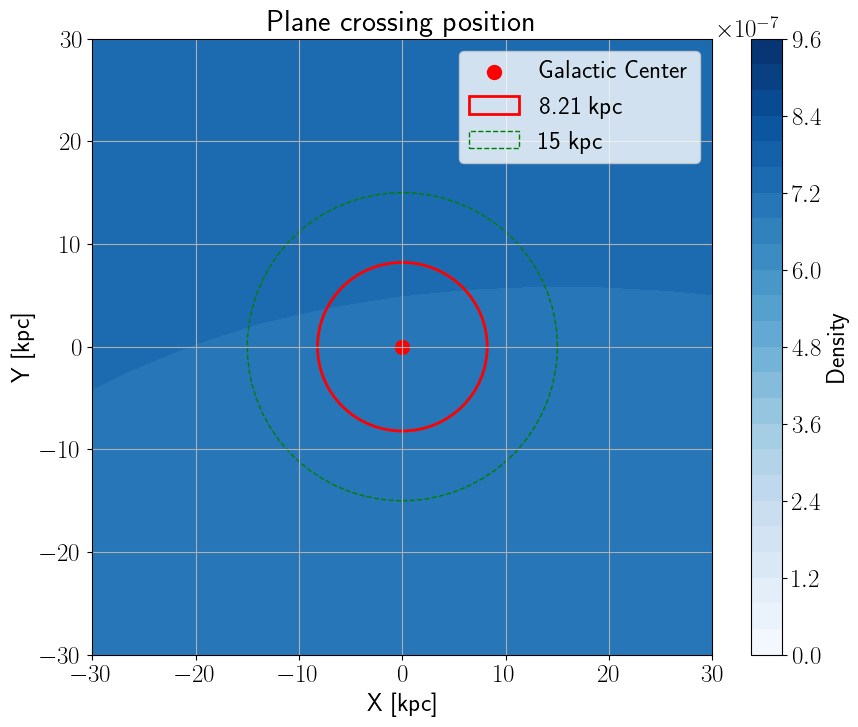

Star: b'HVS 9'


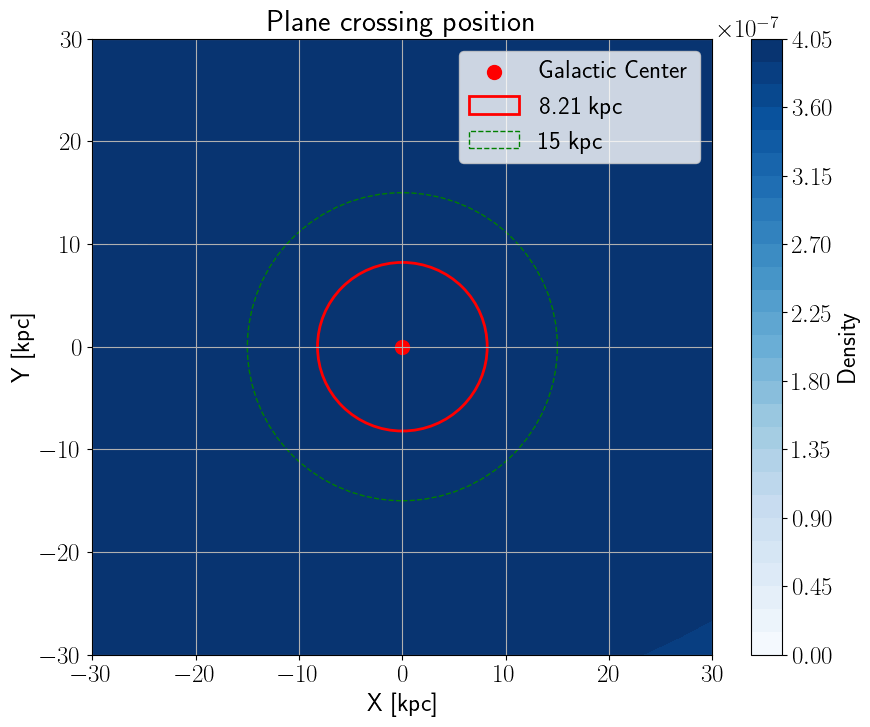

Star: b'HVS 10'


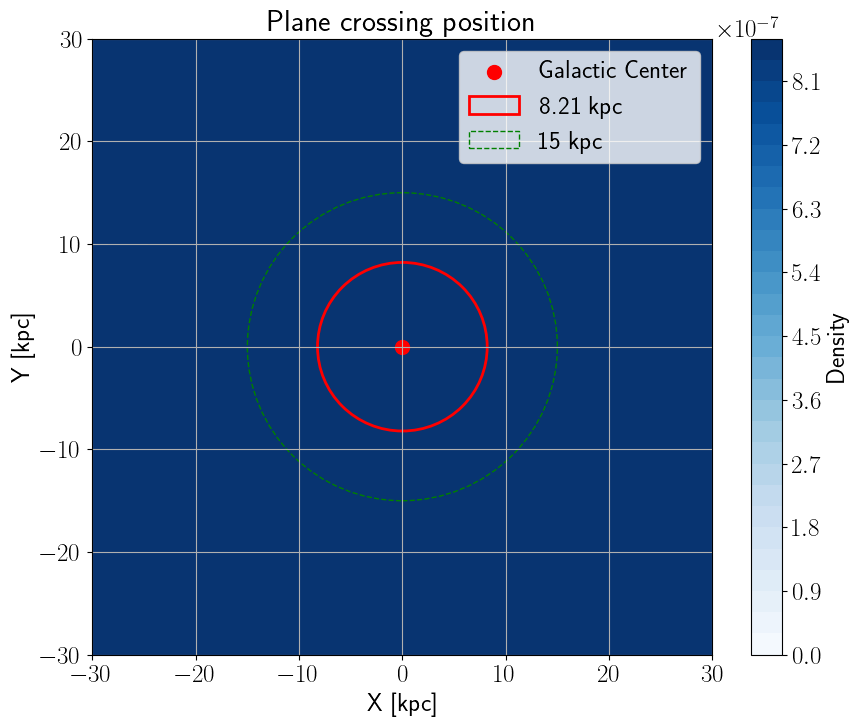

Star: b'HVS 12'


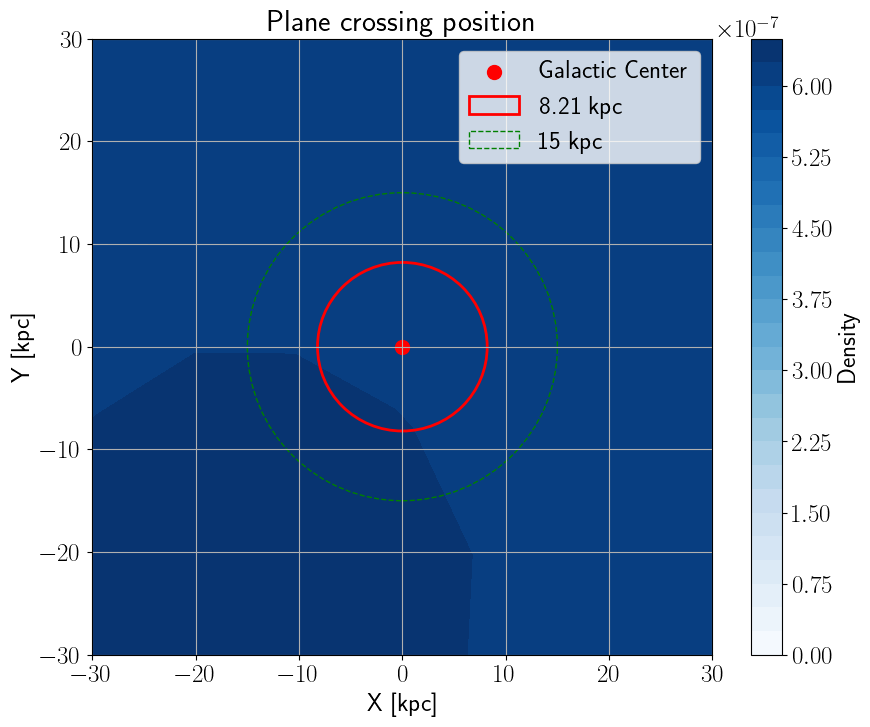

Star: b'HVS 13'


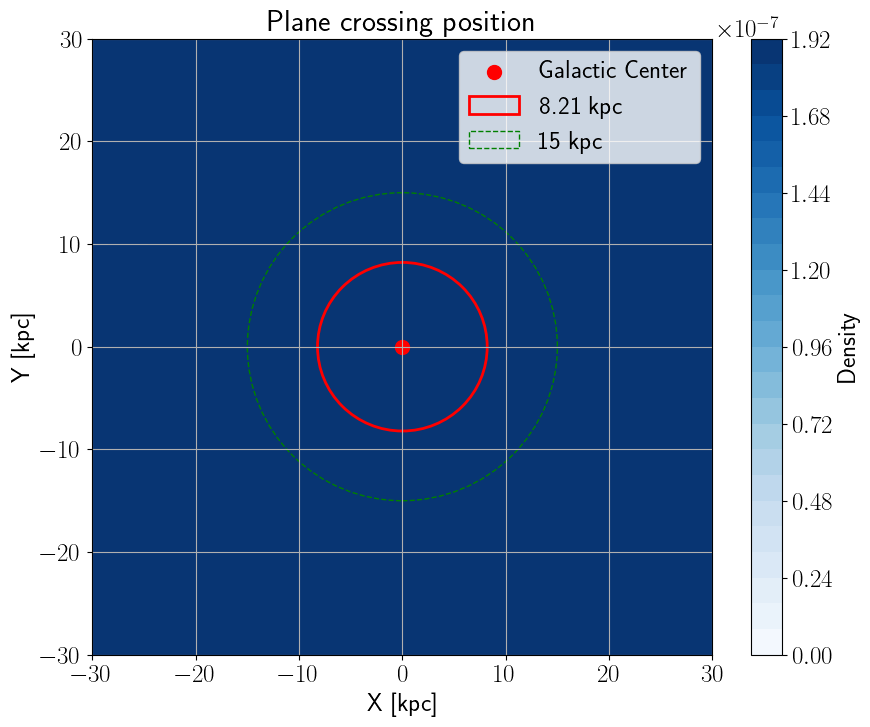

Star: b'B434'


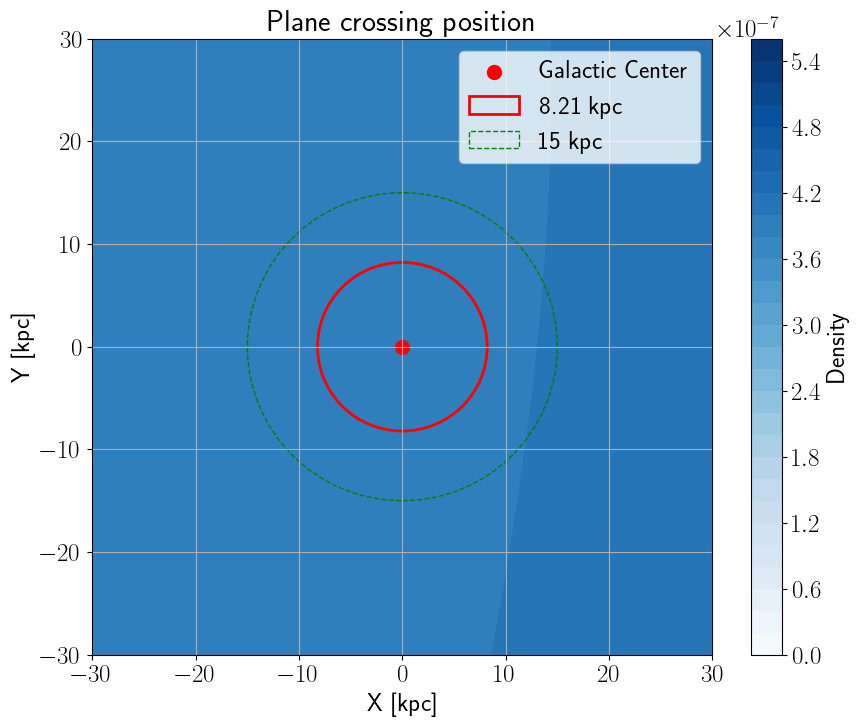

Star: b'B485'


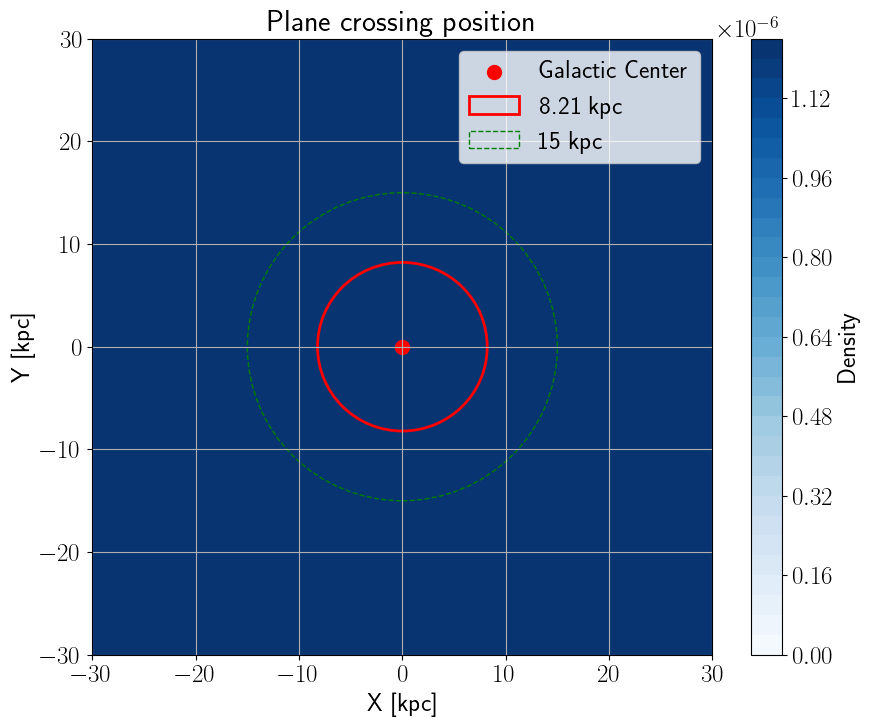

Star: b'B711'


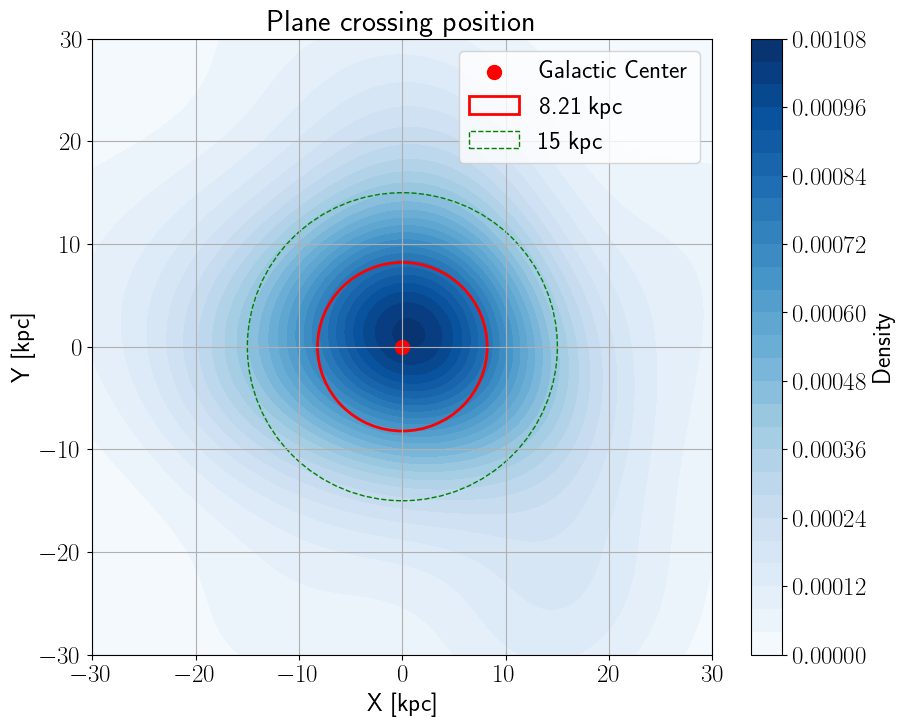

Star: b'B733'


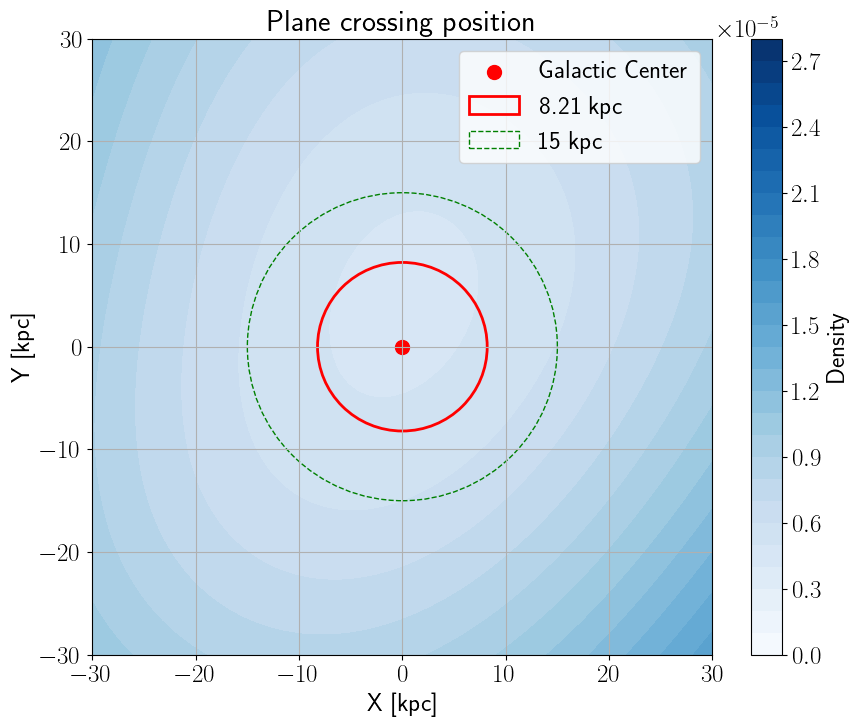

In [85]:
for i in range(len(brown_stars)):
    print('Star:', brown_stars['ID'].iloc[i])
    plot_closest_origins(plane_crossing[i])

## Only plot the $1\sigma$ and $2\sigma$ of the posterior

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_closest_origins_gaussian(origins):
    """
    Fit a 2D Gaussian to the data and plot the 1σ and 2σ contours.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    """
    # Extract X, Y positions
    x = np.array([origin[0].value for origin in origins])
    y = np.array([origin[1].value for origin in origins])
    
    # Validate inputs
    if len(x) == 0 or len(y) == 0:
        raise ValueError("Input data is empty. Ensure 'origins' contains valid points.")
    
    # Fit a 2D Gaussian
    mean = np.array([x.mean(), y.mean()])
    cov = np.cov(x, y)
    
    # Create grid for contour plotting
    xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.meshgrid(xi, yi)
    pos = np.dstack((xi, yi))
    
    # Evaluate the Gaussian PDF
    rv = multivariate_normal(mean, cov)
    zi = rv.pdf(pos)
    
    # Compute 1σ and 2σ levels
    # Compute 1σ and 2σ levels
    levels = np.sort(rv.pdf(mean) * np.array([np.exp(-0.5), np.exp(-2)]))  # Ensure levels are sorted

    
    # Plot data and contours
    plt.figure(figsize=(8, 8))
    #plt.scatter(x, y, alpha=0.5, label='Data Points')
    plt.contour(xi, yi, zi, levels=levels, colors=['blue', 'lightblue'], linewidths=2)
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark Galactic Center
    # add circle with 8.21 kpc radius
    circle = plt.Circle((0, 0), 8.21, color='r', fill=False, linestyle='--', label='8.21 kpc')
    # add circle with a 15 kpc radius
    circle2 = plt.Circle((0, 0), 15, color='g', fill=False, linestyle='--', label='15 kpc')

    plt.gca().add_artist(circle)
    plt.gca().add_artist(circle2)
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    plt.title('Closest Approach Points (2D Gaussian Fit)')
    plt.legend()
    plt.grid(True)
    plt.show()


Star: b'HVS 1'


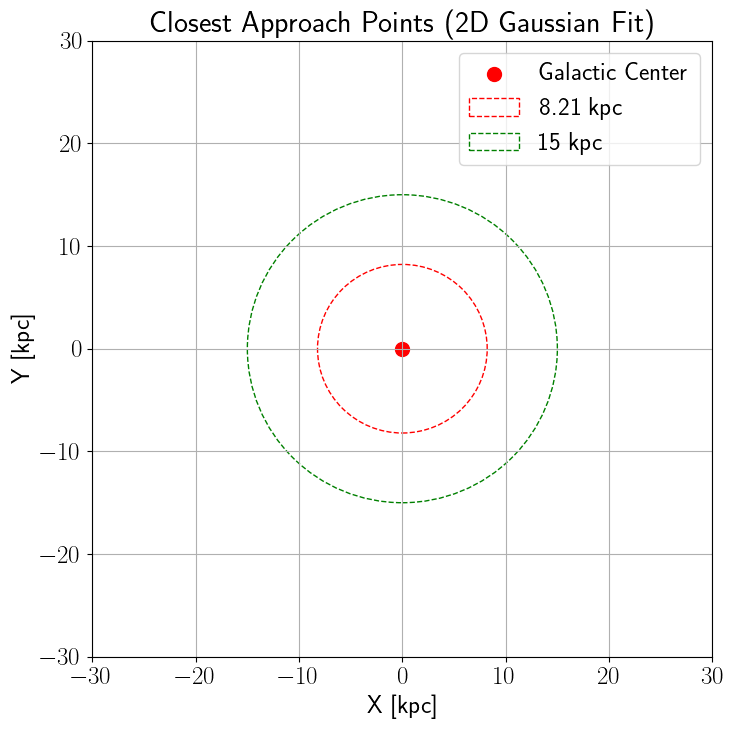

Star: b'HVS 2'


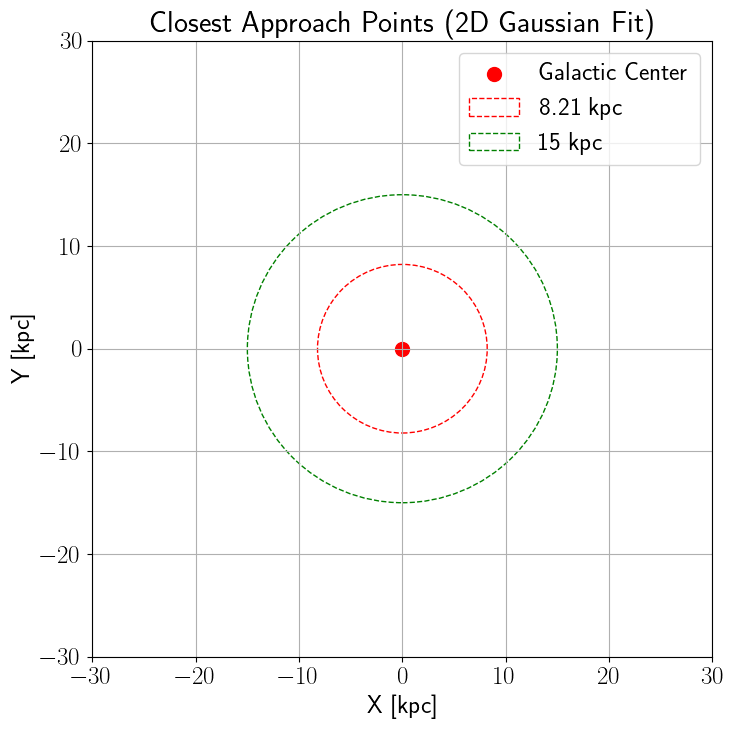

Star: b'HVS 3'


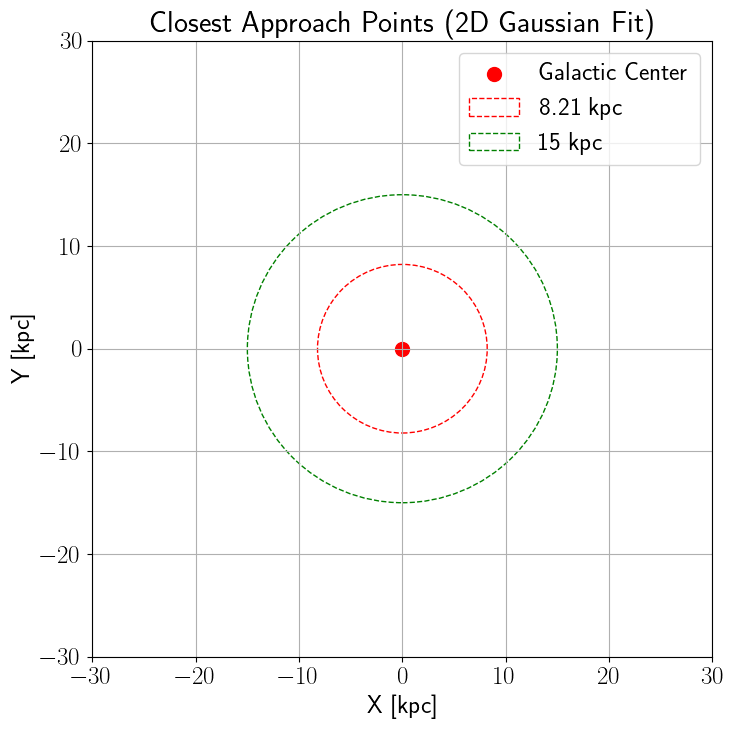

Star: b'HVS 4'


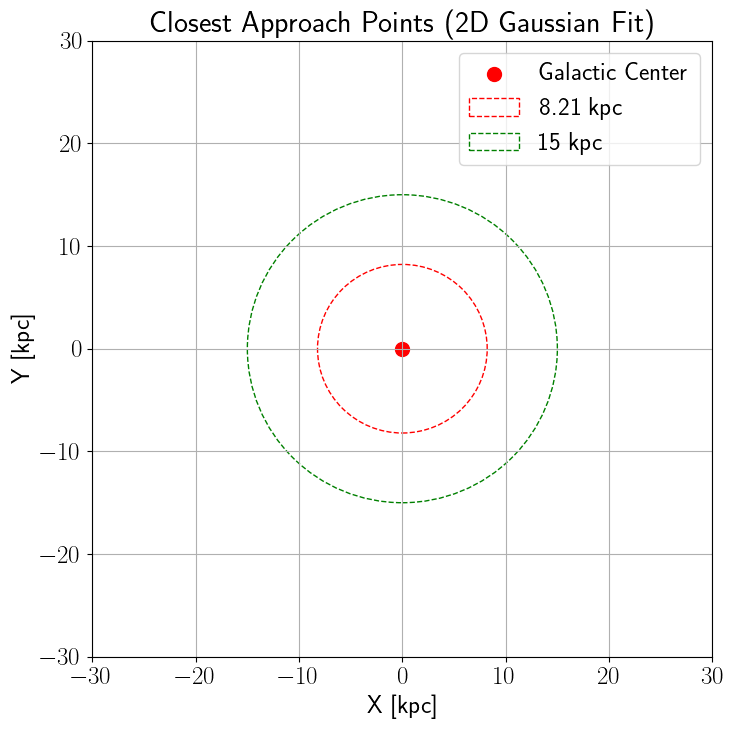

Star: b'HVS 5'


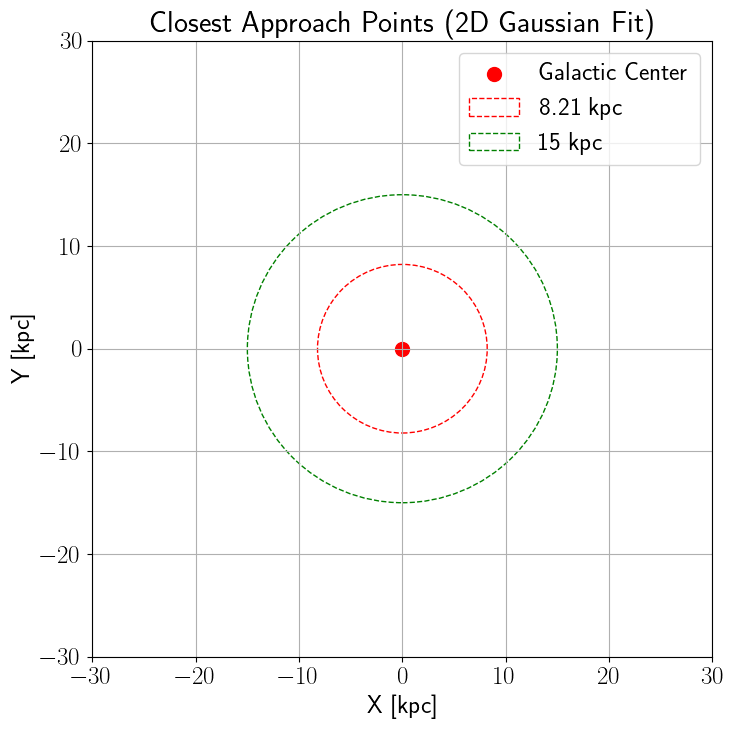

Star: b'HVS 7'


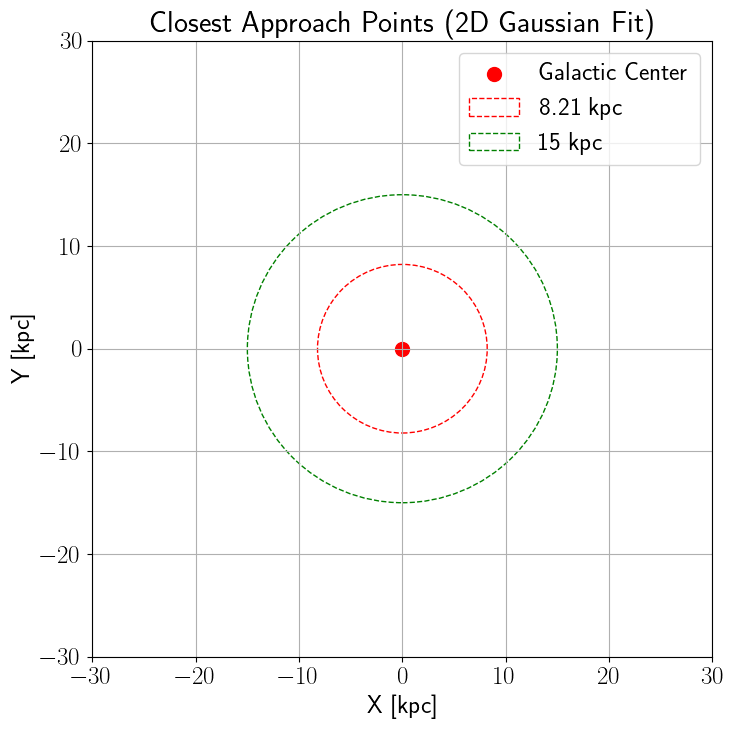

Star: b'HVS 8'


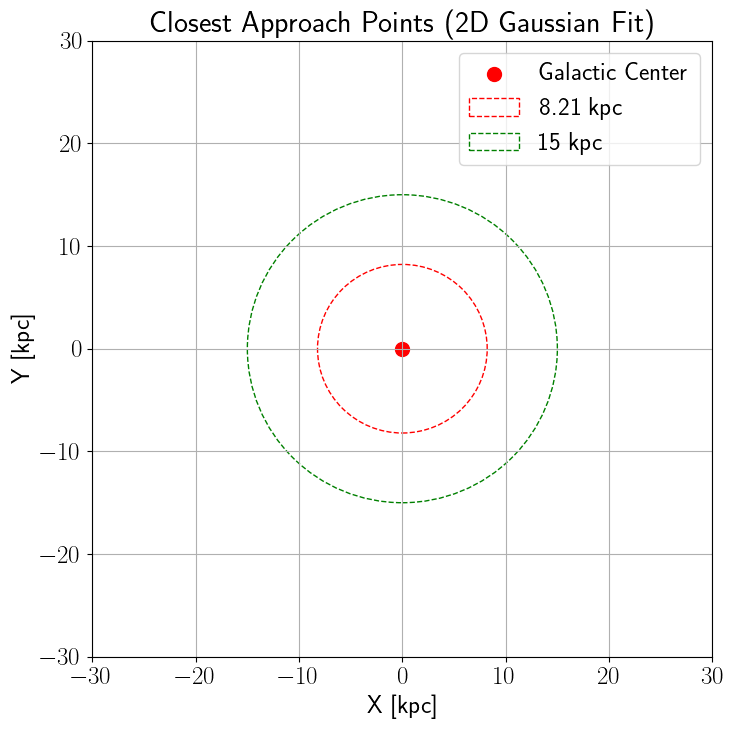

Star: b'HVS 9'


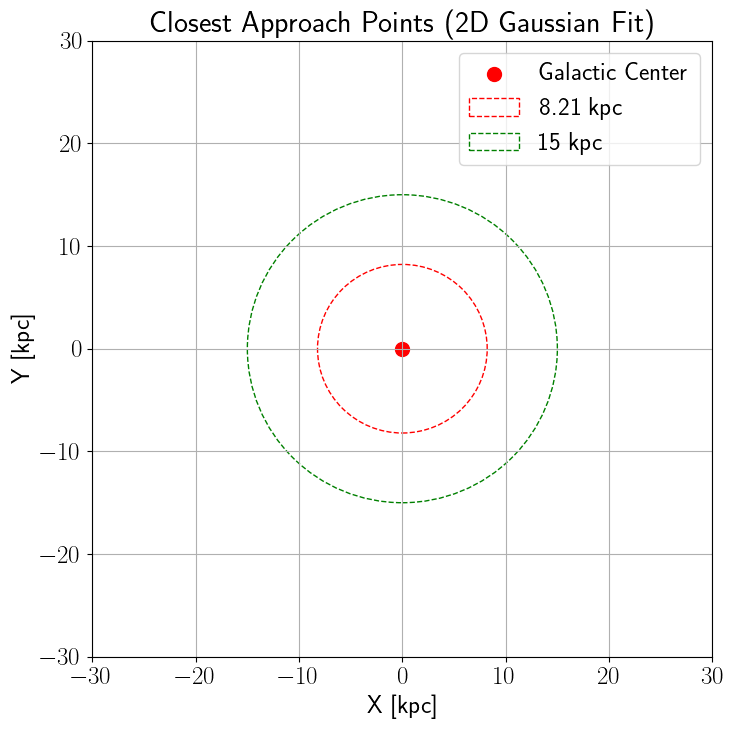

Star: b'HVS 10'


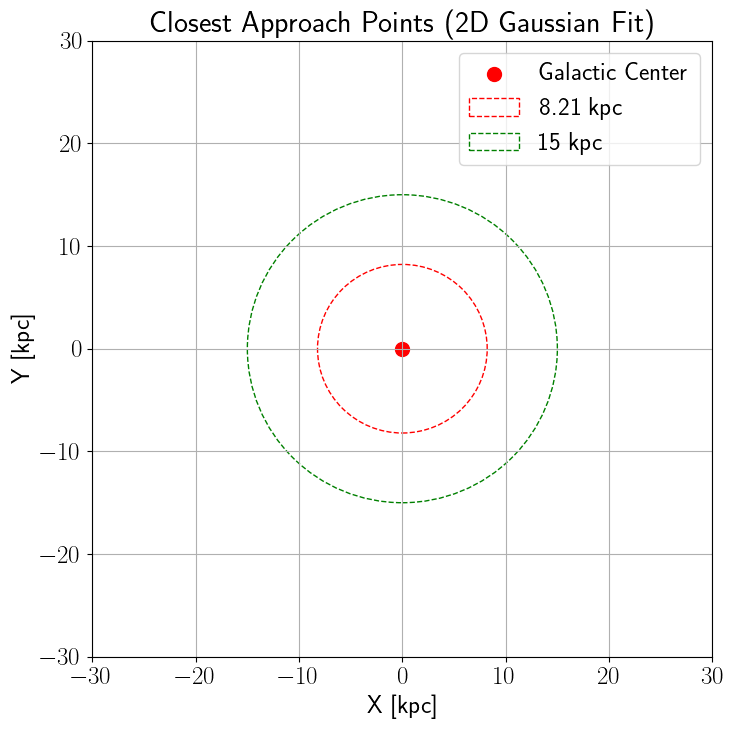

Star: b'HVS 12'


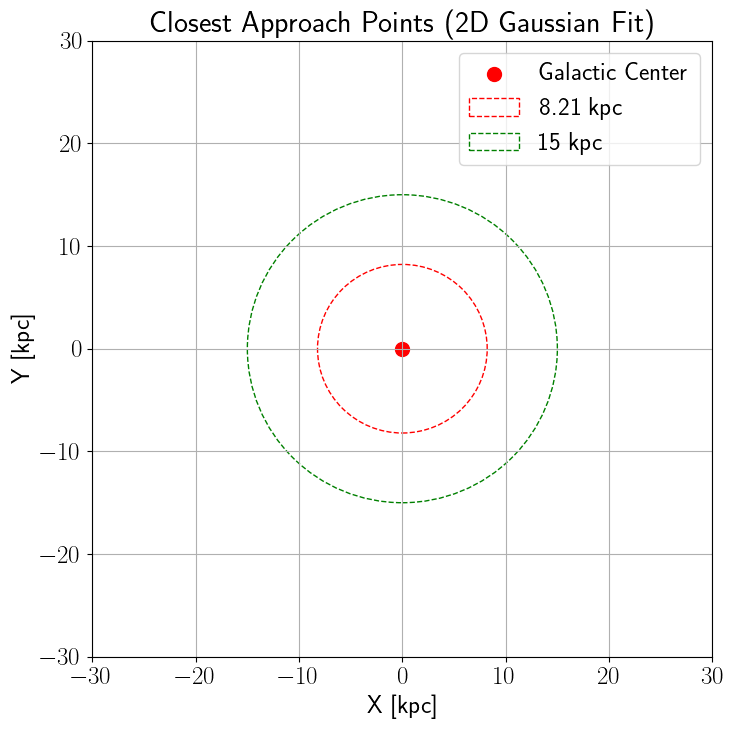

Star: b'HVS 13'


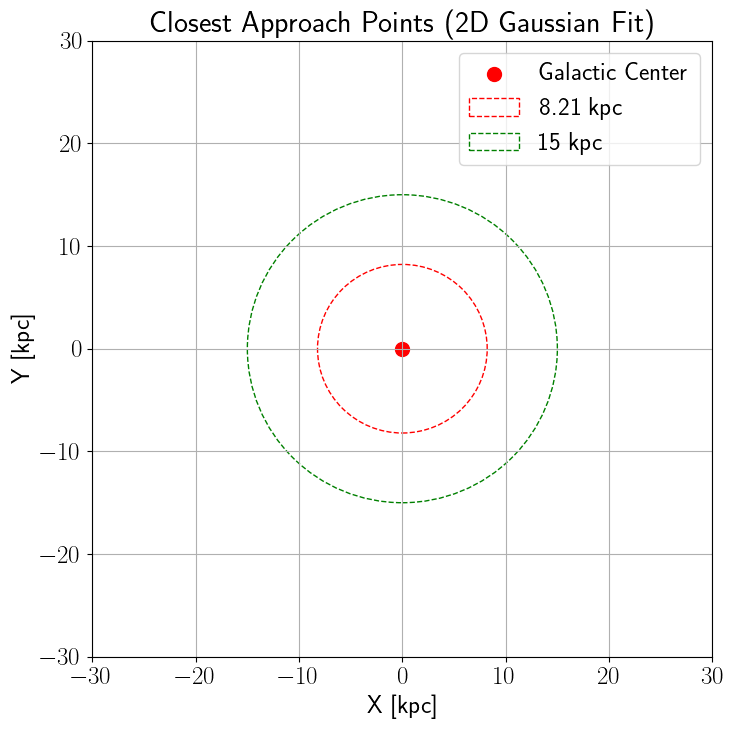

Star: b'B434'


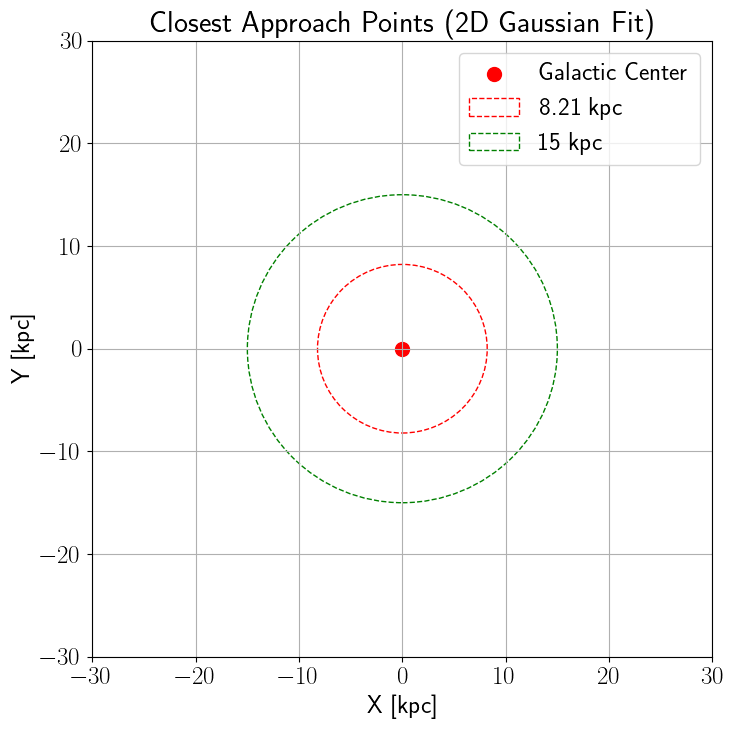

Star: b'B485'


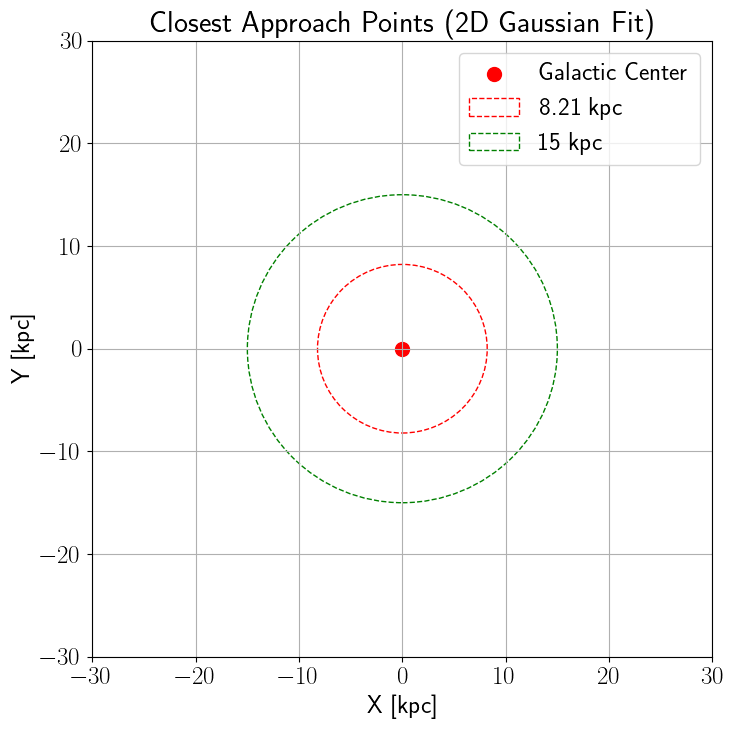

Star: b'B711'


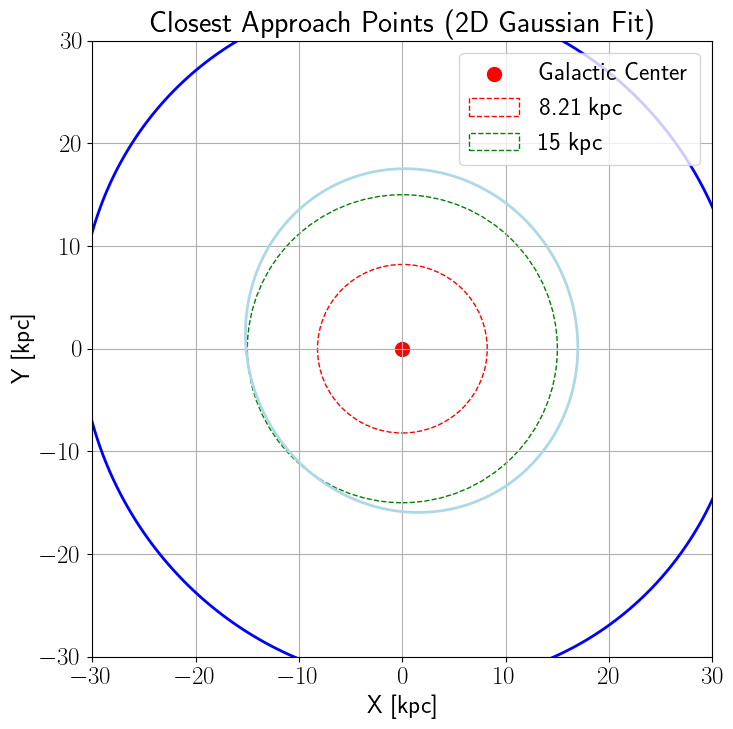

Star: b'B733'


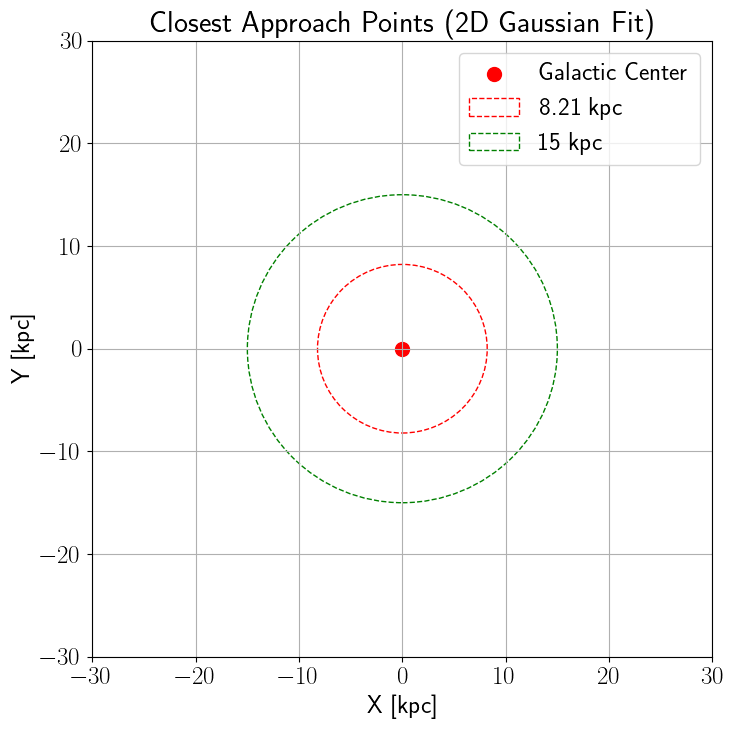

In [90]:
for i in range(len(brown_stars)):
    print('Star:', brown_stars['ID'].iloc[i])
    plot_closest_origins_gaussian(plane_crossing[i])

# Using their Hubble proper motions

In [72]:
# now for all stars
path_to_save = '/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/orbits'
plane_crossing = []
for i in tqdm(range(len(brown_stars))):
    origins = integrate_orbits_to_plane_crossing_mcmillan(brown_stars.iloc[[i]], n_samples=100, integration_time=-100*u.Myr, n_steps=1000, pmra_col='mu_ra', pmdec_col='mu_dec', pmra_error_col='mu_ra_error', pmdec_error_col='mu_dec_error')
    plane_crossing.append(origins)


100%|██████████| 15/15 [01:04<00:00,  4.30s/it]


Star: b'HVS 1'


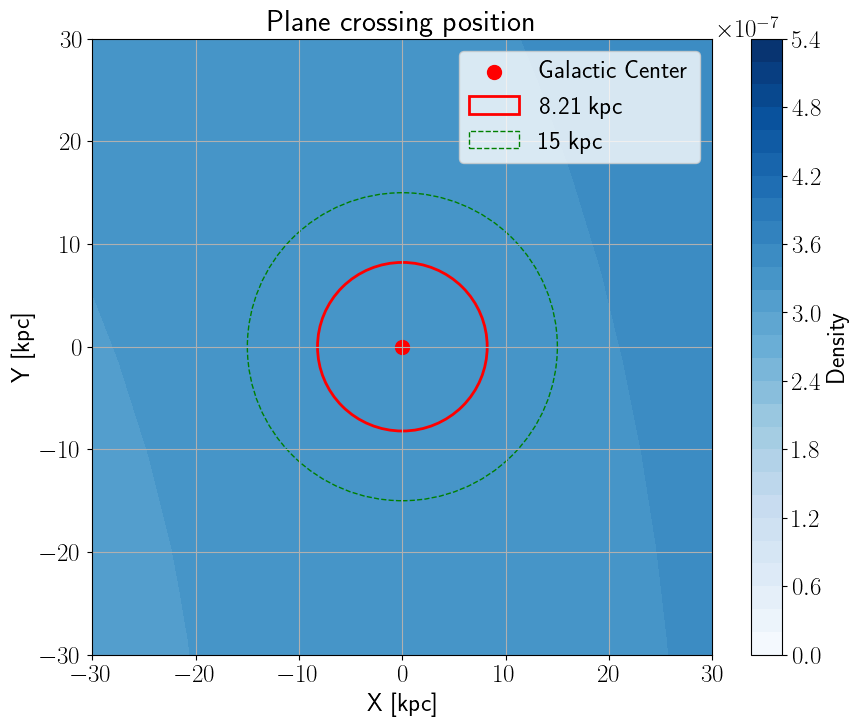

Star: b'HVS 2'


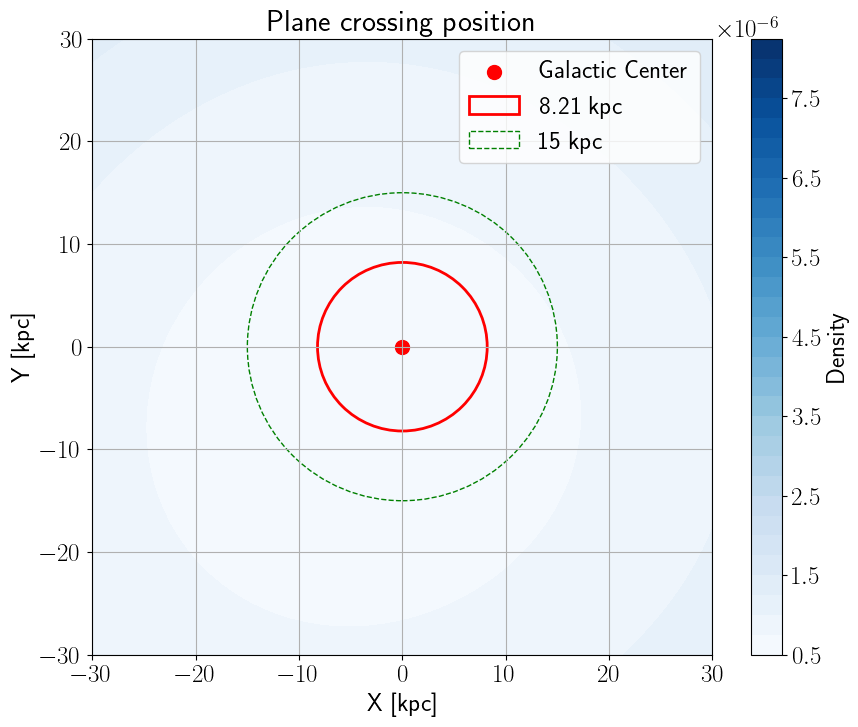

Star: b'HVS 3'


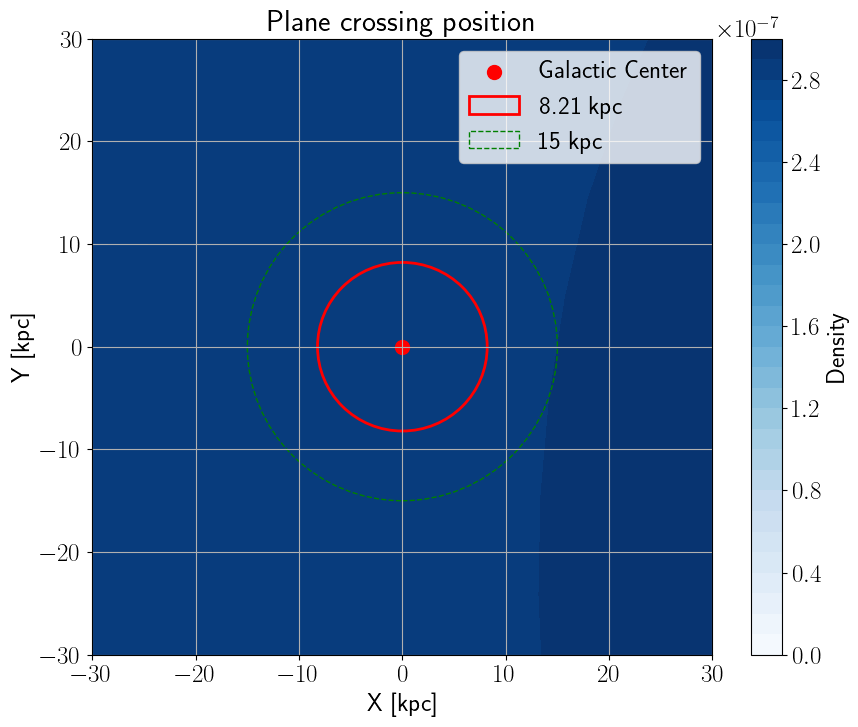

Star: b'HVS 4'


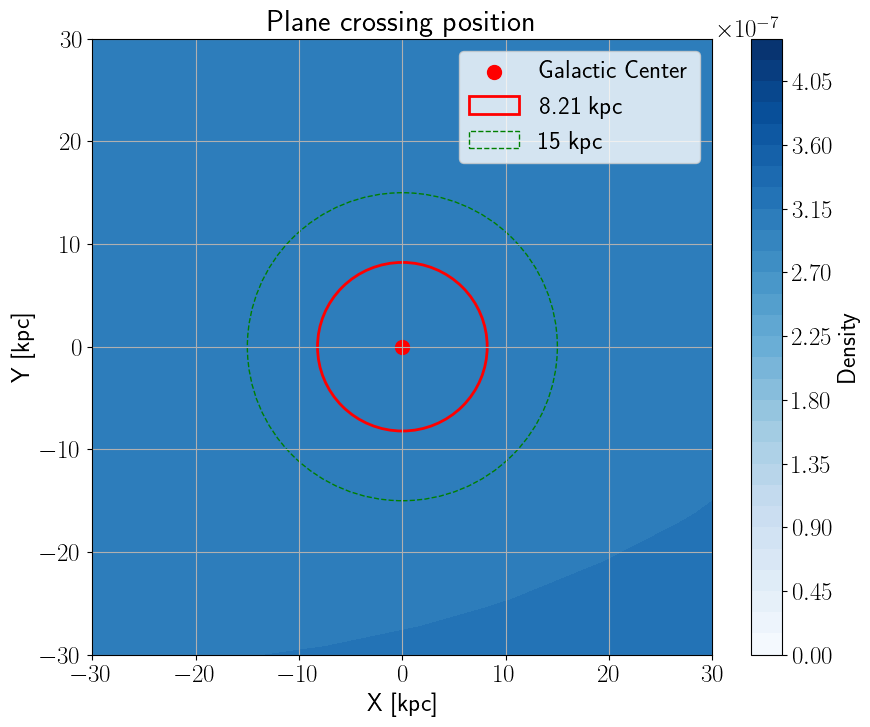

Star: b'HVS 5'


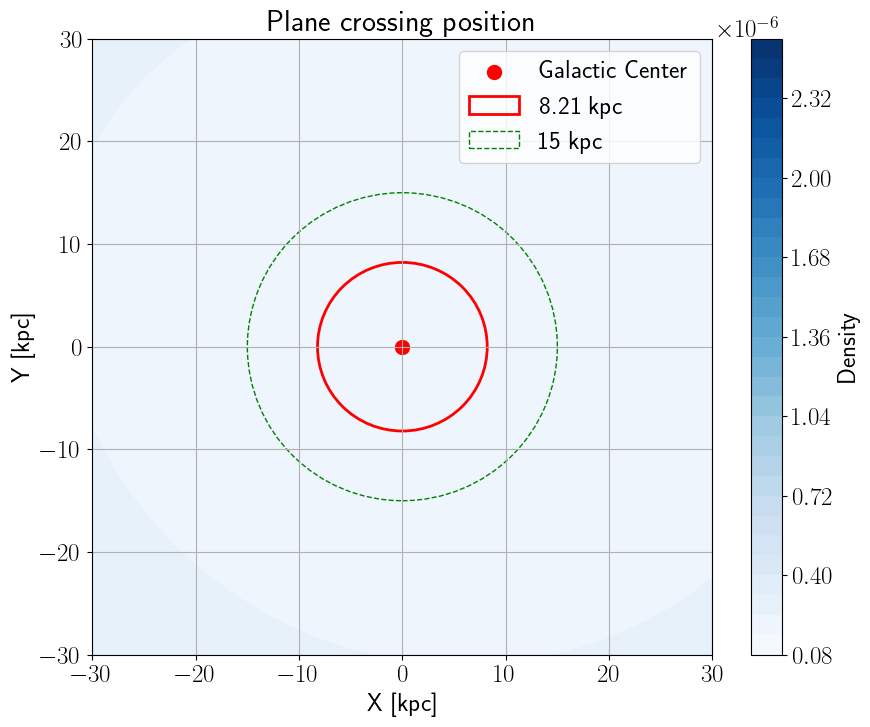

Star: b'HVS 7'


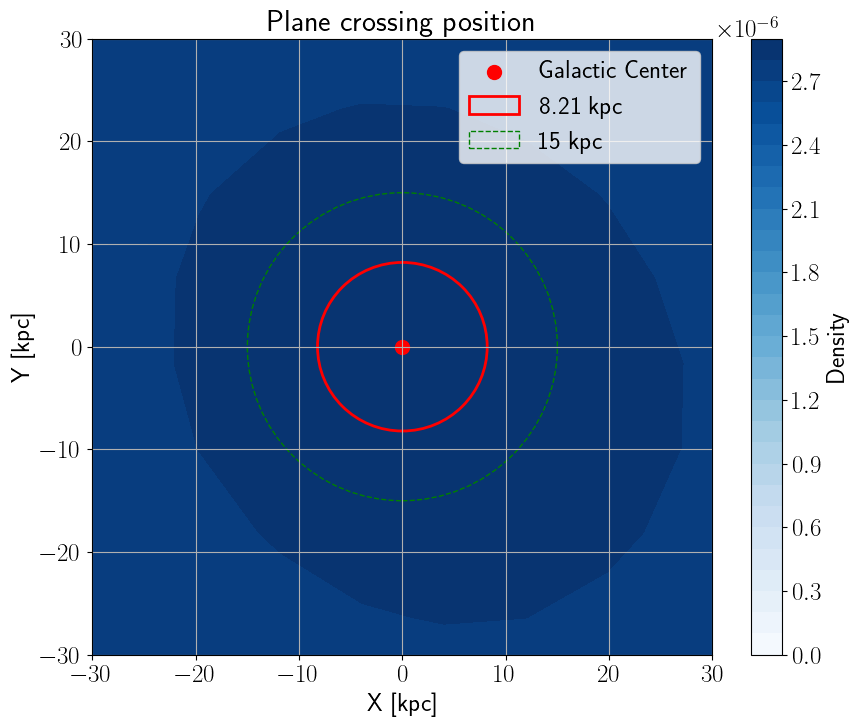

Star: b'HVS 8'


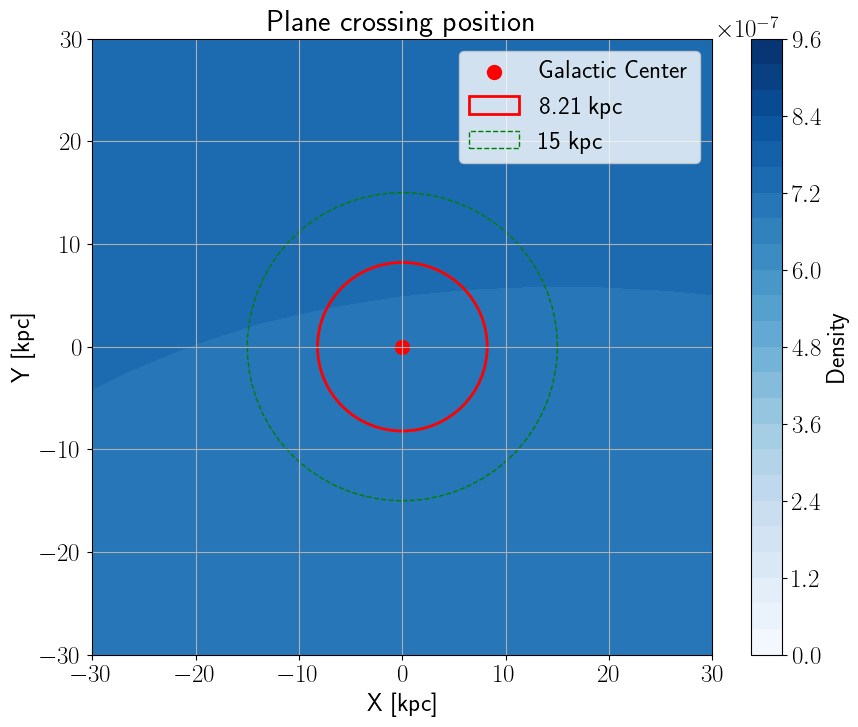

Star: b'HVS 9'


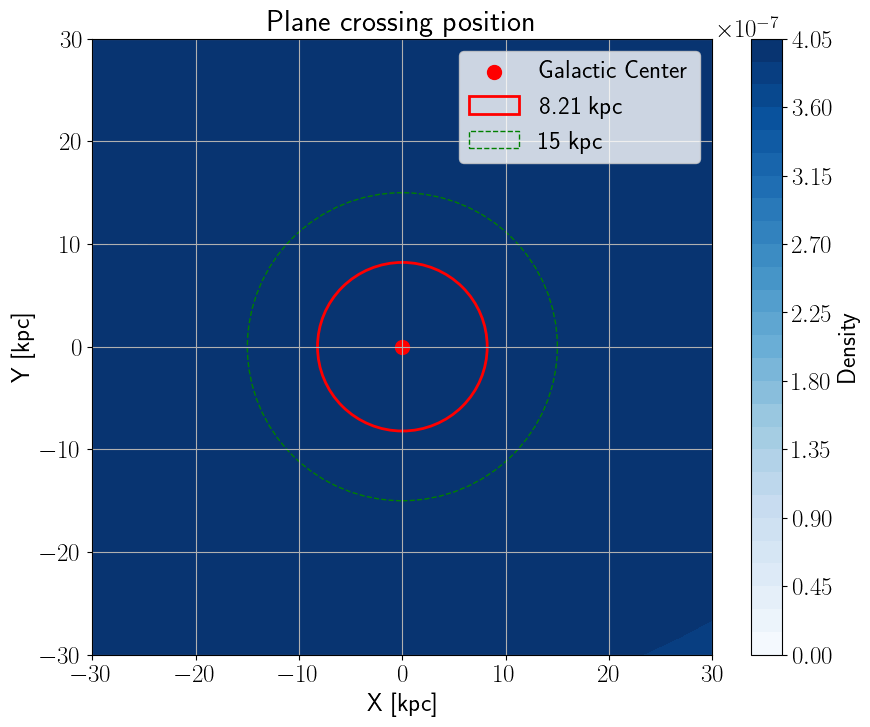

Star: b'HVS 10'


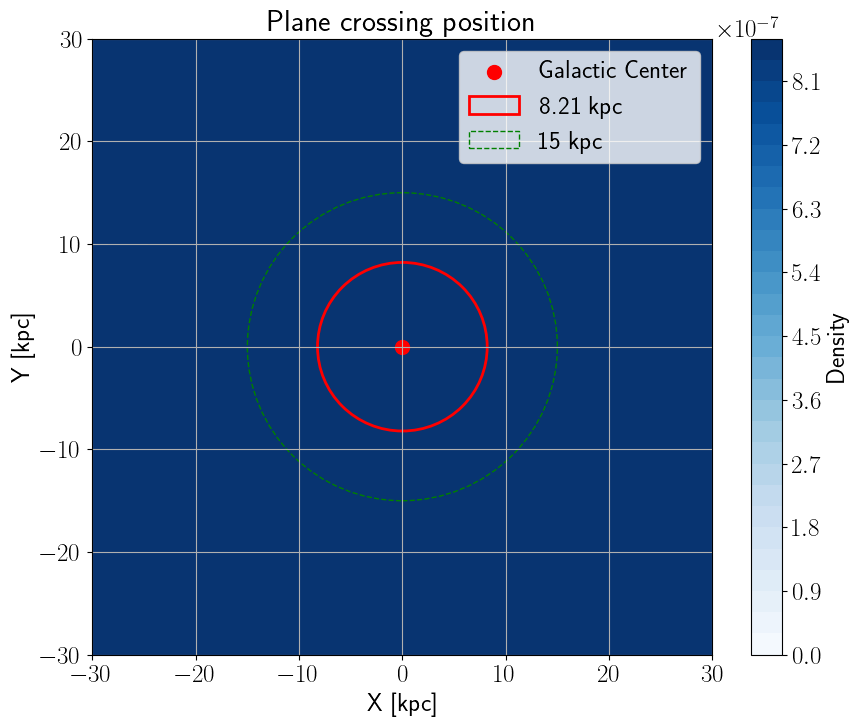

Star: b'HVS 12'


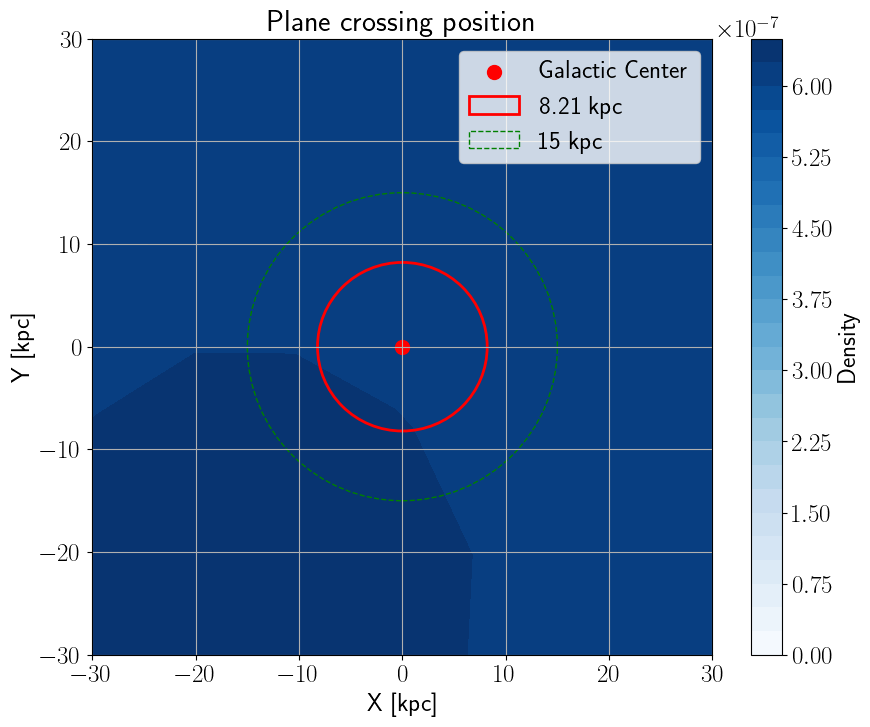

Star: b'HVS 13'


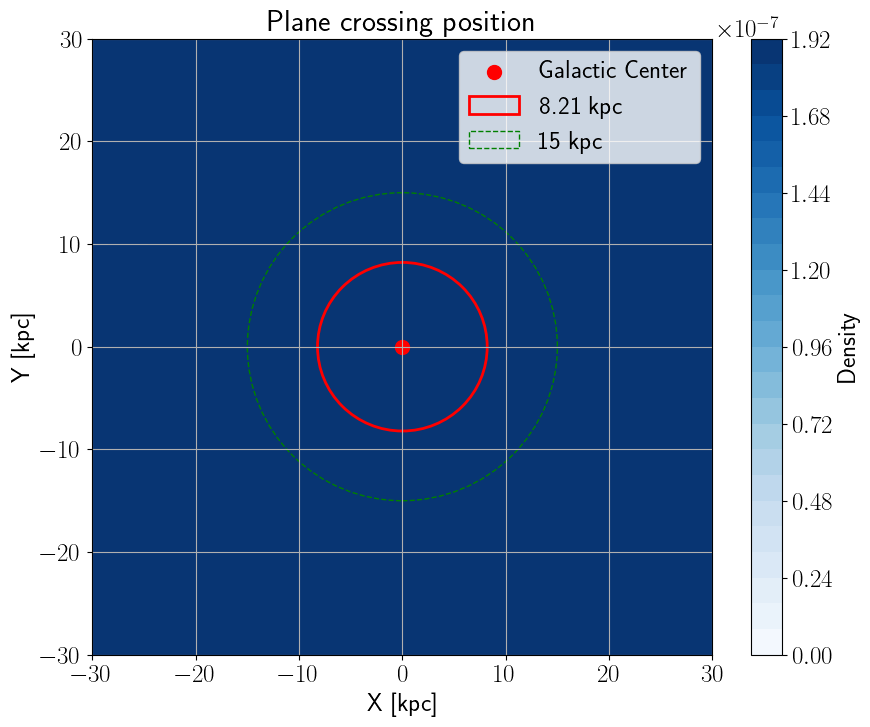

Star: b'B434'


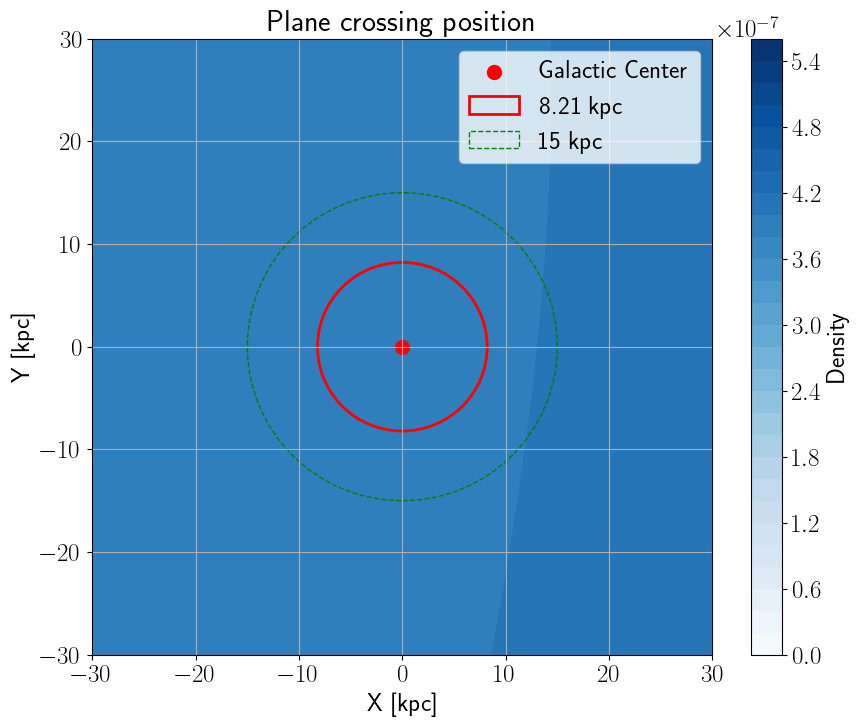

Star: b'B485'


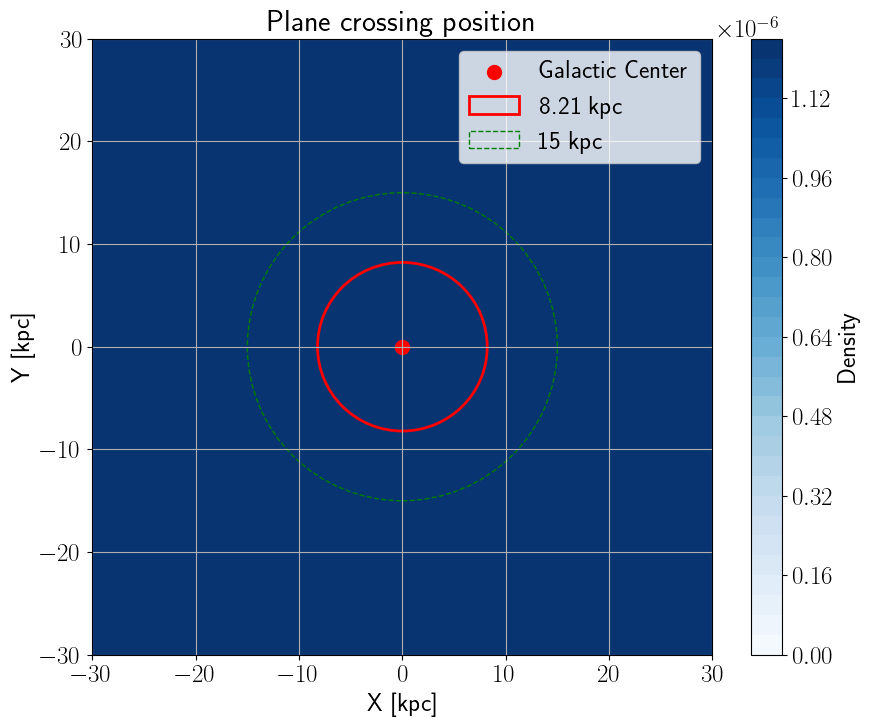

Star: b'B711'


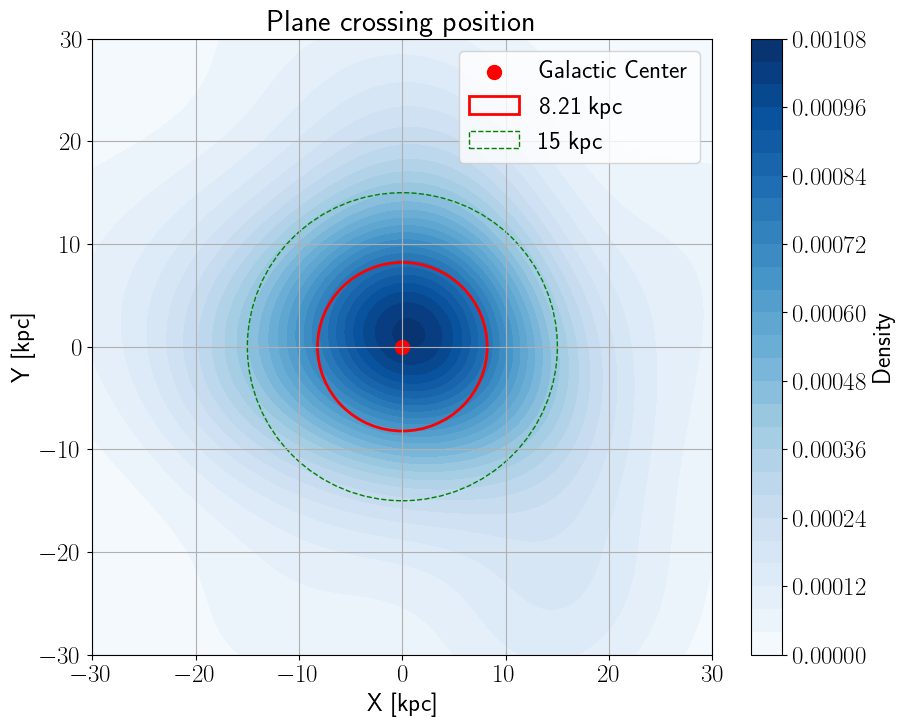

Star: b'B733'


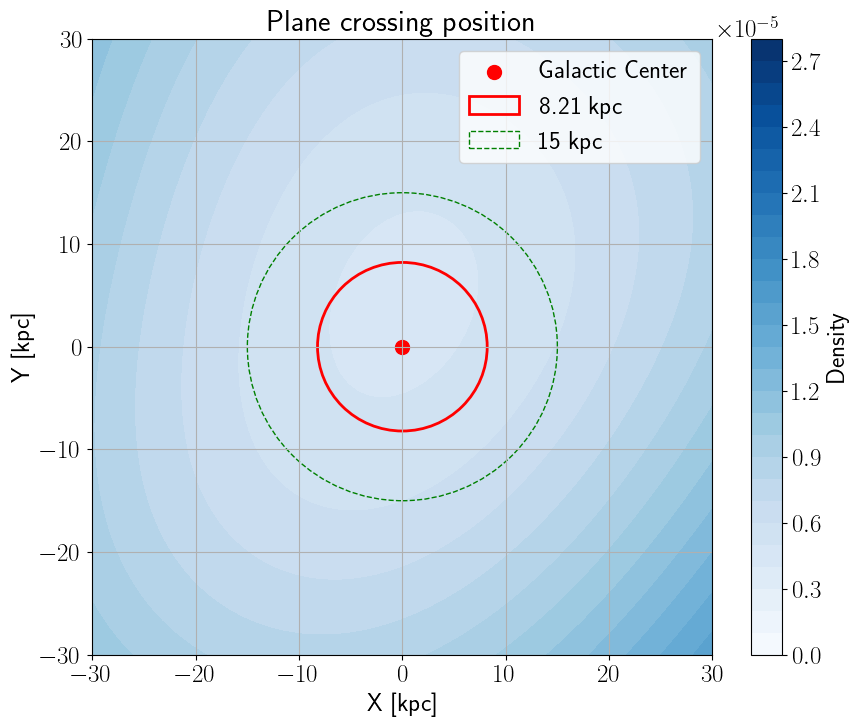

In [81]:
for i in range(len(brown_stars)):
    print('Star:', brown_stars['ID'].iloc[i])
    plot_closest_origins(plane_crossing[i], xlim=(-30, 30), ylim=(-30, 30))

# With Hubble x Gaia proper motions for HVS2

In [93]:
# load hvs2 data
hvs2 = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/hvs2_hubblexgaia.fits')
hvs2 = hvs2.to_pandas()

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/units/core.py:2157: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)



In [108]:
# integrate orbit with McMillan17 potential and updated proper motions
origin_hvs2 = integrate_orbits_to_plane_crossing_mcmillan(hvs2, n_samples=100,
                                                           integration_time=-100*u.Myr,
                                                             n_steps=1000,
                                                               pmra_col = 'pmra',
                                                                 pmdec_col='pmdec',
                                                                 pmra_error_col='pmra_error', 
                                                                 pmdec_error_col='pmdec_error')


100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


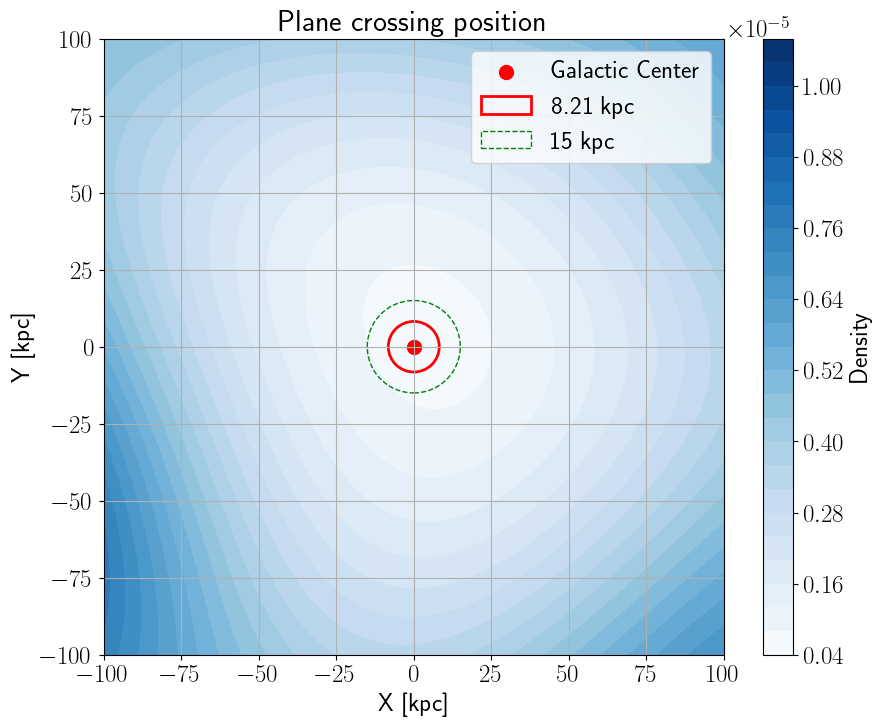

In [109]:
plot_closest_origins(origin_hvs2, xlim=(-100, 100), ylim=(-100, 100))

# Hubble x Gaia for HVS4

In [105]:
# load hvs4 data
hvs4 = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/hvs4_hubblexgaia_rewind.fits')
hvs4 = hvs4.to_pandas()

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/units/core.py:2157: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)



In [134]:
# integrate orbit with McMillan17 potential and updated proper motions
origin_hvs4 = integrate_orbits_to_plane_crossing_mcmillan(hvs4, n_samples=1000, integration_time=120*u.Myr,
                                                          n_steps=1000, pmra_col = 'hst_gaia_pmra_wmean', 
                                                          pmdec_col='hst_gaia_pmdec_wmean', 
                                                          pmra_error_col='hst_gaia_pmra_wmean_error', 
                                                          pmdec_error_col='hst_gaia_pmdec_wmean_error')


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:39<00:00, 25.03it/s]


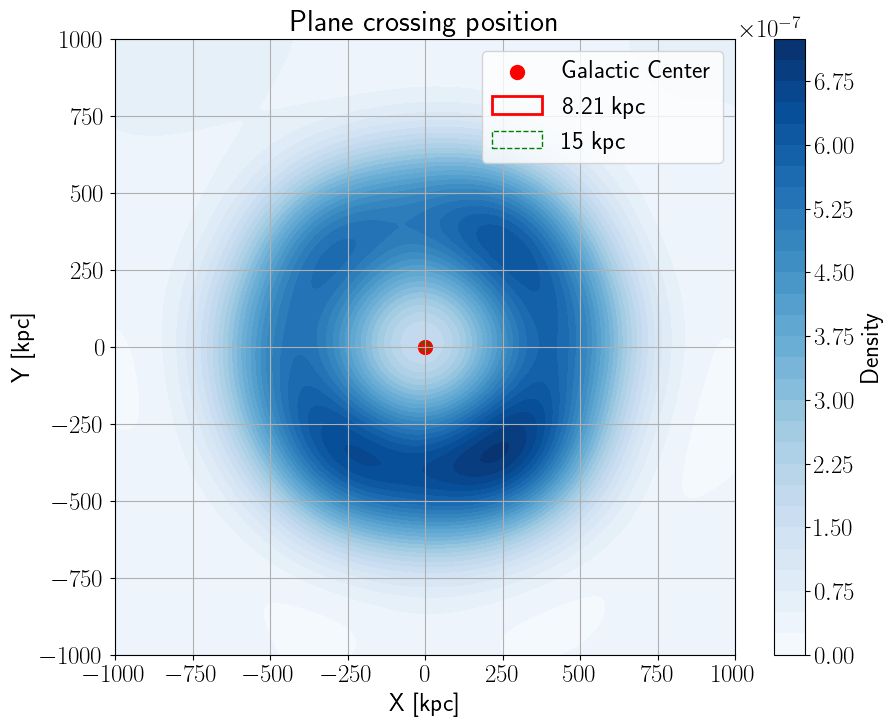

In [135]:
plot_closest_origins(origin_hvs4, xlim=(-1000, 1000), ylim=(-1000, 1000))

# Do this objects come from the LMC?

In [122]:
# load lmc orbit


lmc_orbit = Table.read('/Users/mncavieres/Documents/2023-1/Investigacion2/Data/LMC_orbits/LMC5_suborbit.fits')

In [126]:
# parametric interpolation

import numpy as np

def interpolate_3d_polynomial(x, y, z, degree, n):
    # Parameterize the curve by its cumulative arc length or another parameter
    t = np.linspace(0, 1, len(x))  # Simple linear parameterization
    
    # Fit a polynomial of the specified degree to each coordinate
    poly_x = np.polyfit(t, x, degree)
    poly_y = np.polyfit(t, y, degree)
    poly_z = np.polyfit(t, z, degree)
    
    # Generate a new set of parameter values for interpolation
    t_new = np.linspace(0, 1, n)
    
    # Evaluate the polynomials at the new parameter values
    x_new = np.polyval(poly_x, t_new)
    y_new = np.polyval(poly_y, t_new)
    z_new = np.polyval(poly_z, t_new)
    
    return x_new, y_new, z_new

new_x, new_y, new_z = interpolate_3d_polynomial(x, y, z, 10, n)


In [130]:
# convert to galactic coordinates
lmc_orbit_coords_int = SkyCoord(new_x, new_y, new_z, frame='galactic', unit='kpc', representation_type = 'cartesian')
lmc_orbit_coords_int = lmc_orbit_coords_int.transform_to('icrs')

In [128]:
interp_orbit = Table()
interp_orbit['x'] = new_x
interp_orbit['y'] = new_y
interp_orbit['z'] = new_z
interp_orbit['l'] = lmc_orbit_coords_int.galactic.l.degree
interp_orbit['b'] = lmc_orbit_coords_int.galactic.b.degree
interp_orbit['ra'] = lmc_orbit_coords_int.icrs.ra.degree
interp_orbit['dec'] = lmc_orbit_coords_int.icrs.dec.degree
#interp_orbit.write('/Users/mncavieres/Documents/2023-1/Investigacion2/Data/LMC_orbits/LMC5_orbit_interp.fits', overwrite = True)

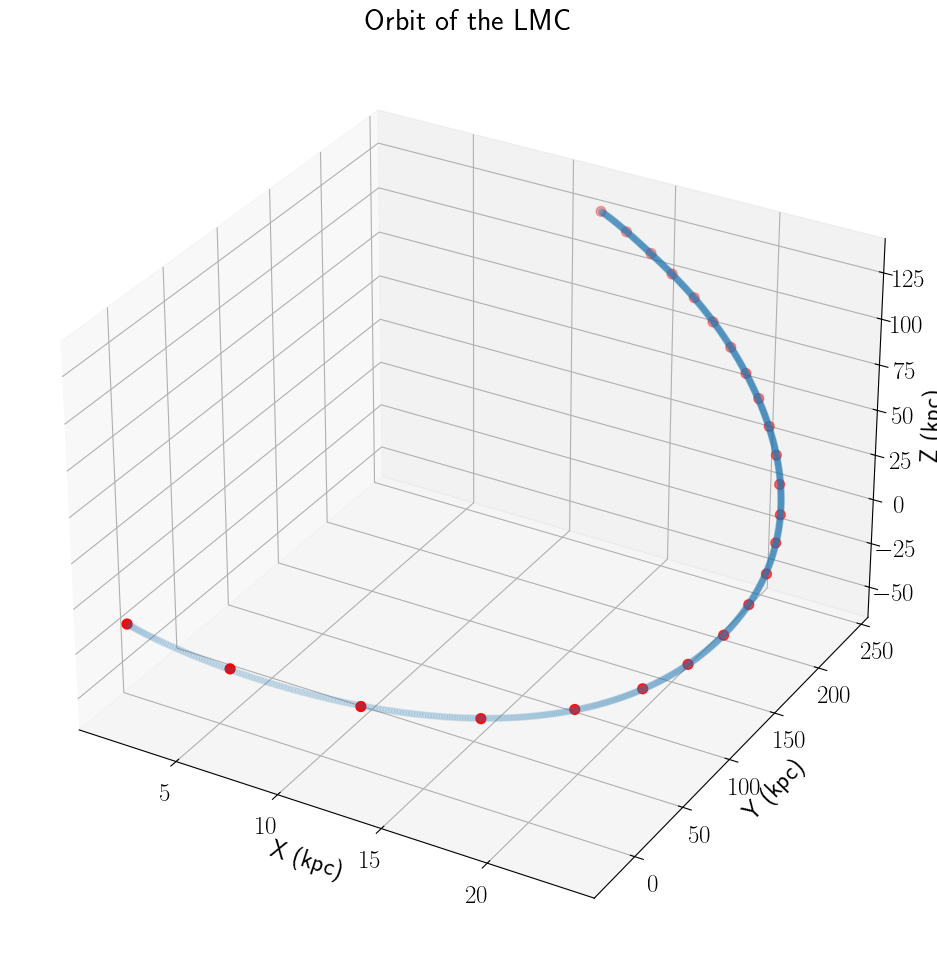

In [129]:
# Import the required libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(new_x, new_y, new_z, alpha = 0.1)
ax.scatter(x, y, z, color='red', s = 50)  # Original points in red



# Set labels and title
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')
ax.set_title('Orbit of the LMC')

# Show the plot
plt.show()


## Plot with the lmc orbit

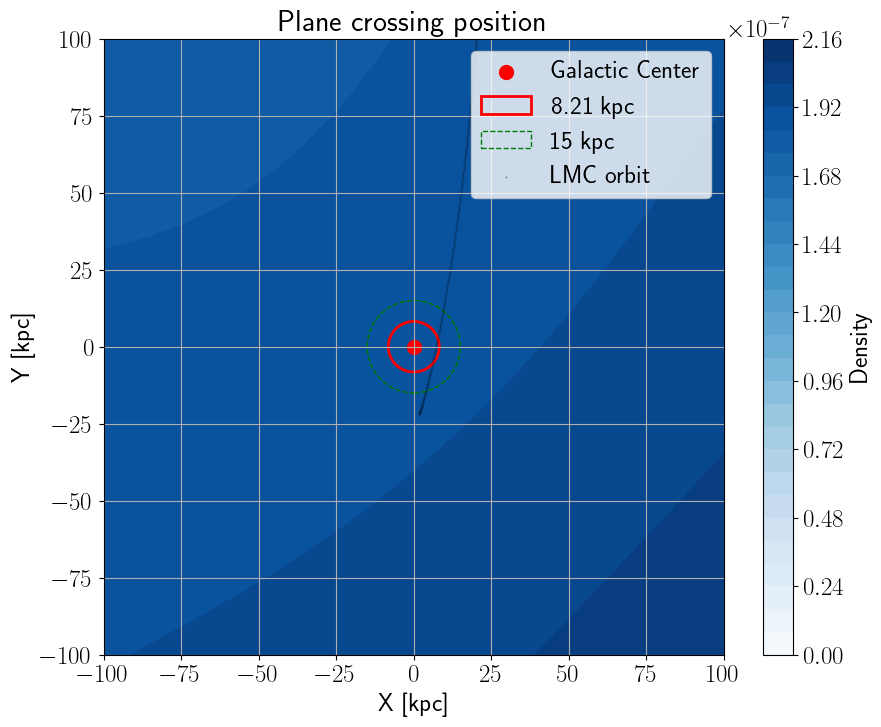

In [133]:
xlim = (-100, 100)
ylim = (-100, 100)
# Extract X, Y positions
x = np.array([origin[0].value for origin in origin_hvs4])
y = np.array([origin[1].value for origin in origin_hvs4])

# Create a 2D KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
xi, yi = np.meshgrid(xi, yi)
zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

# Plot the KDE as a contour plot
plt.figure(figsize=(10, 8))
plt.contourf(xi, yi, zi, levels=30, cmap="Blues")
plt.colorbar(label="Density")
plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark the Galactic Center

# solar circle
circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
# add circle with a 15 kpc radius
circle2 = plt.Circle((0, 0), 15, color='g', fill=False, linestyle='--', label='15 kpc')
plt.gca().add_artist(circle1)
plt.gca().add_artist(circle2)

plt.scatter(new_x, new_y, alpha = 0.5, c = 'black', label = 'LMC orbit', s= 0.1)

plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Plane crossing position')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()
